# 1. Import development dataset (ZDC database)

In [1]:
import pandas as pd
import numpy as np

file_name = 'data/ZDC_20JAN22_maart2023.csv'

df_zdc = pd.read_csv(file_name, sep=';')
df_zdc = df_zdc.drop(columns=['BSNnummer'])

# Suspicion according to GP
d_IRD_GP = { 
    'RA' : 1,
    'PMR' : 1,
    'Jicht' : 1,
    'Seclerodermie' : 1,
    'SLE' : 1,
    'PsA' : 1,
    'SpA' : 1,
    'Sjogren' : 1,
    'reactief artritis' : 1,
    'Verdenking systeemziekte' : 1,
    'verdenking op artritis' : 1,
    'Verdenking RA/Art Psoriatica' : 1,
    'Verdenking systeemziekte' : 0,
    'pseudojicht' : 1,
    
    # No IRD
    'FMS' : 0,
    'sarcoidose' : 0,
    'tendomyogeen' : 0,
    'Artrose' : 0,
    
    # unclear
    'stijfheid' : 0,
    'Artralgie (gerichtspijn)' : 0,
    'anders' : 0,
    'weet het niet onbekend' : 0,
    '#NULL!' : 0,
    '999' : 0
}


# 'Primair Fenomeen van Raynaud'
# Perniones

# Remove empty column
df_zdc = df_zdc.drop(columns=['Unnamed: 3'])

# fill invalid with nan
df_zdc['v7.17'] = df_zdc['v7.17'].replace('98', np.nan)

# Original verwijsreden
df_zdc['VERHA_ORIGINAL'] = df_zdc['VERHA'].copy()

# replace text with max value
df_zdc['v4.1'] = df_zdc['v4.1'].replace('overal', '20') # Replace 'overall' with max value (20) in column 
df_zdc['VERHA_DIAG'] = df_zdc['VERHA'].apply(lambda x : d_IRD_GP[x])
df_zdc['VERHA'] = df_zdc['VERHA'].astype('category').cat.codes

# Rename falsely named columns
df_zdc = df_zdc.rename(columns = {'v6.9' : 'v6.12', 'v6.10' : 'v6.13'})

# Create map with labels
d_sex = dict(zip(df_zdc['ZDNnummer'], df_zdc['Geslacht']))
d_verha = dict(zip(df_zdc['ZDNnummer'], df_zdc['VERHA']))
d_verha_original = dict(zip(df_zdc['ZDNnummer'], df_zdc['VERHA_ORIGINAL']))
d_verhadiag = dict(zip(df_zdc['ZDNnummer'], df_zdc['VERHA_DIAG']))

# Remove patients with improper identifier & missing age (as they are not traceable)
print('Number of patients in ZDC database: ', len(df_zdc['ZDNnummer'].unique()))

df_zdc.to_csv('proc/df_zdc_full.csv', sep=';', index=None)

Number of patients in ZDC database:  862


#### Offshoot analysis: Check overlap primary physician & rheumatologist (not in paper)

In [2]:

from sklearn.metrics import classification_report
import pandas as pd

# Create classification report
report_dict = classification_report(df_zdc['Diagnose'], df_zdc['VERHA_ORIGINAL'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Filter to diagnosis labels
diagnosis_labels = sorted(set(df_zdc['Diagnose']) | set(df_zdc['VERHA_ORIGINAL']))
report_df_filtered = report_df.loc[diagnosis_labels]

# Rename support column
report_df_filtered = report_df_filtered.rename(columns={'support': 'n_rheumatologist'})

# GP label counts
gp_counts = df_zdc['VERHA_ORIGINAL'].value_counts()
report_df_filtered['n_gp'] = report_df_filtered.index.map(gp_counts).fillna(0).astype(int)

# Overlap: cases where GP and Rheumatologist gave the same label
overlap_counts = df_zdc[df_zdc['VERHA_ORIGINAL'] == df_zdc['Diagnose']]['VERHA_ORIGINAL'].value_counts()
report_df_filtered['n_overlap'] = report_df_filtered.index.map(overlap_counts).fillna(0).astype(int)

# Round other metrics
report_df_filtered = report_df_filtered.round(0)

print(report_df_filtered[['n_gp', 'n_rheumatologist', 'n_overlap']].fillna(0).astype(int))

                                          n_gp  n_rheumatologist  n_overlap
#NULL!                                       3                 3          3
999                                          6                 6          6
Artralgie (gerichtspijn)                   124                 0          0
Artrose                                     28               152         21
FMS                                         79               110         57
GPA vasculitis                               0                 1          0
Hypermobiliteit Syndroom                     0                23          0
Jicht                                       55                49         40
Ongedeferentieerd artritis                   0                10          0
PMR                                         55                27         22
PsA                                         41                29         17
RA                                         118                87         50
SLE         

/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

### 1.1 Standardize data 

In [3]:

d_groups_old = {'weet het niet onbekend' : 'Ambig', 
            'anders' : 'Ambig',
            'onbekend' : 'Ambig',
            # Autoimmune diseases
            'RA' : 'REU', 
            'PMR' : 'REU', 
            'Jicht' : 'REU', 
            'SLE': 'REU',
             'PsA': 'REU',
            'SpA' : 'REU', 
            'Sjogren' : 'REU',
            'Sjögren' : 'REU',
            'sarcoidose' : 'REU', 
            'reactief artritis' : 'REU', 
            'reactieve artritis' : 'REU',
            'Ongedeferentieerd artritis': 'REU',
            'ongedifferentieerde artritis' : 'REU',
            'pseudojicht': 'REU',
            'Sclerodermie' : 'REU', 
            'GPA vasculitis' : 'REU',
            'Paraneoplastisch' : 'REU',
            'Verdenking op een reumatische aandoening': 'REU', 
            # Non Autoimmune diseases
            'Artrose' : 'NoREU',
            'tendomyogeen': 'NoREU',
            'FMS' : 'NoREU',  
            'Raynaud' : 'NoREU',
            'Perniones' : 'NoREU',
            'Hypermobiliteit Syndroom' : 'NoREU', 
            'Hypermobiliteitssyndroom' : 'NoREU',
            'Primair Fenomeen van Raynaud' : 'NoREU'
            }


d_final_labels = { 
    'RA' : 'RA',#'Rheumatoid arthritis', 
    'PMR' : 'PMR',# 'Polymyalgia rheumatica',
    'Jicht' : 'Gout',
    'SLE' : 'SLE', # 'Systemic Lupus Erythematosus',
    'Sclerodermie' : 'SLE', #'Systemic Lupus Erythematosus',
    'PsA' : 'Psoriatic Arthritis',
    'SpA' : 'Spondyloarthritis',
    'Sjogren' : 'Sjogren disease',
    'Sjögren' : 'Sjogren disease',
    'reactief artritis': 'Reactive arthritis',
    'reactieve artritis' : 'Reactive arthritis',
    'UA' : 'undifferentiated arthritis',
    'Ongedeferentieerd artritis' : 'undifferentiated arthritis',
    'ongedifferentieerde artritis' :'undifferentiated arthritis',
    'Seclerodermie' : 'Systemic sclerosis',
    'pseudojicht' : 'CPPD', # Calcium pyrophosphate deposition (CPPD)also known as “pseudogout”
    'dd RMD' : 'Probable RMD in development',
    'Verdenking op een reumatische aandoening' : 'Probable RMD in development',
    'Verdenking systeemziekte' : 'Probable RMD in development',
    'sarcoidose' : 'Sarcoidosis',
    'GPA vasculitis' : 'ANCA associated vasculitis',
    'Artrose' : 'Osteoarthritis',    
    'tendomyogeen' : 'Tendinopathy',
    'FMS' : 'Fibromyalgia',
    'Raynaud' : 'Raynaud phenomenon',
    'Perniones' : 'Pernio',
    'Hypermobiliteitssyndroom' : 'Hypermobility',
    'Hypermobiliteits syndroom' : 'Hypermobility', 
    'Hypermobiliteit Syndroom' : 'Hypermobility',
    'anders' : 'Other',
    'onbekend' : 'Unknown'
 }

df_zdc = df_zdc.fillna(np.nan)
df_zdc['Category'] = df_zdc['Diagnose'].map(d_groups_old)
d_category = dict(zip(df_zdc['ZDNnummer'], df_zdc['Category']))
y = df_zdc['Diagnose']

#### 1.1.1 Check how many patients have clear annotation

In [4]:
print('patients with ambiguous labels = %s ; patients with clear labels = %s '% ( len(df_zdc[df_zdc['Category']=='Ambig']), len(df_zdc[df_zdc['Category']!='Ambig'])))

patients with ambiguous labels = 127 ; patients with clear labels = 735 


#### 1.1.2 Show prevalence of diagnoses

(117, 27, 97, 152, 10, 110, 87, 49, 23, 12, 52, 18, 13, 29, 30, 10, 6, 5, 6, 3, 5, 1)


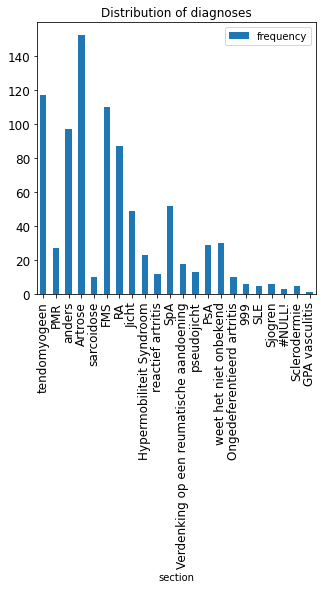

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

labels, values = zip(*Counter(y).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Distribution of diagnoses", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=90)
plt.show()

#### 1.1.3 Show prevalence of IRD (REU) vs non-IRD (noREU)

(402, 324, 127)


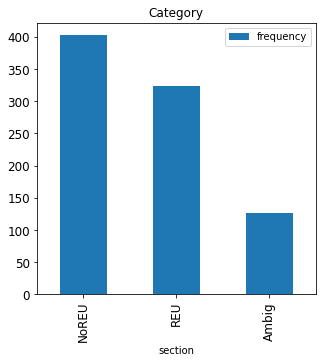

In [6]:
labels, values = zip(*Counter(df_zdc[df_zdc['Category'].isin(['NoREU', 'REU', 'Ambig'])]['Category']).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Category", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=90)
plt.show()

# 862 - 726

#### Now including nans

(402, 324, 127, 9)


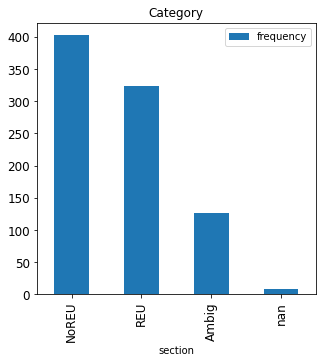

In [7]:
labels, values = zip(*Counter(df_zdc['Category']).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Category", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=90)
plt.show()

# 862 - 726

### 1.2 Preprocess data

In [8]:
d_map_sex = {'Man' : 0, 'Vrouw' : 1, '999': np.nan,  '#NULL!' : np.nan}

# Select questions
cols_of_interest = [i for i in df_zdc.columns if i not in ['verwijzing', 'Reumafactor',  'antiCCP', 'HLA B27','CRP','BSE', 'Röntgenfoto','Geslacht','VERHA', 'Diagnose', 'Inflammatoire', 'Inflammatoire', 'afbeelding A', 'afbeelding B', 'verwijzing', 'Opmerkingen', 'VAR00002',]]

# Infer missingness
df_zdc['verwijzing'] = df_zdc['verwijzing'].replace('x', np.nan)

# Process geslacht
df_zdc['Geslacht'] = df_zdc['Geslacht'].apply(lambda x : d_map_sex[x])


### 1.2.1 Show missingness heatmap

<AxesSubplot:>

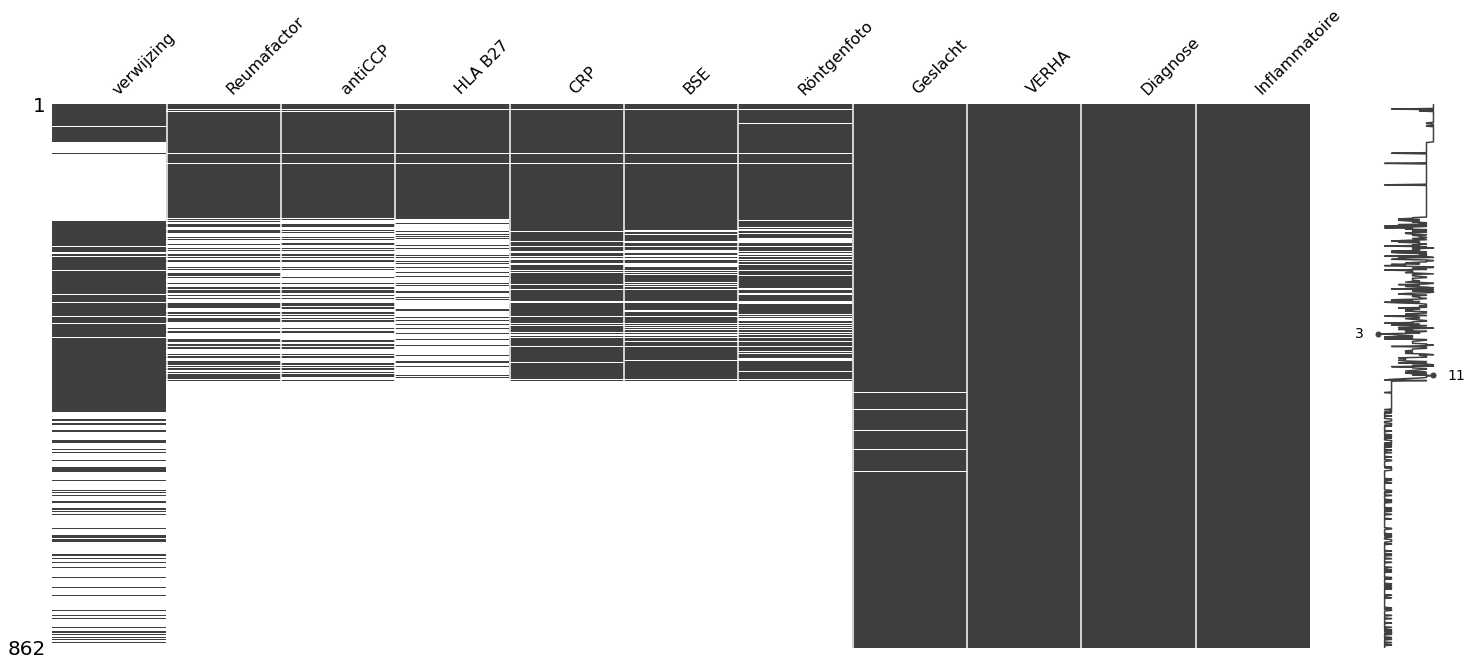

In [9]:
l_extra = ['verwijzing', 'Reumafactor',  'antiCCP', 'HLA B27','CRP','BSE', 'Röntgenfoto','Geslacht','VERHA', 'Diagnose', 'Inflammatoire',]#

import missingno as msno
    
%matplotlib inline
msno.matrix(df_zdc[l_extra]) # check if patients that miss variables across lines -> have aCCP / RF of 2

### 1.2.2 Preprocess Lab values (not in paper)

In [10]:
df_zdc['Reumafactor'] = df_zdc['Reumafactor'].astype(str)
df_zdc['Reumafactor'] = df_zdc['Reumafactor'].apply(lambda x: x.replace('<', ''))
df_zdc['Reumafactor'] = df_zdc['Reumafactor'].replace('#NULL!', np.nan)
df_zdc['Reumafactor'] = df_zdc['Reumafactor'].replace('nan', np.nan)
df_zdc['Reumafactor'] = df_zdc['Reumafactor'].astype(float)

# Process BSE
df_zdc['BSE'] = df_zdc['BSE'].astype(str)
df_zdc['BSE'] = df_zdc['BSE'].apply(lambda x: x.replace('<', ''))
df_zdc['BSE'] = df_zdc['BSE'].replace('#NULL!', np.nan)
df_zdc['BSE'] = df_zdc['BSE'].replace('nan', np.nan)
df_zdc['BSE'] = df_zdc['BSE'].astype(float)

# Process CRP
df_zdc['CRP'] = df_zdc['CRP'].astype(str)
df_zdc['CRP'] = df_zdc['CRP'].apply(lambda x: x.replace('<', ''))
df_zdc['CRP'] = df_zdc['CRP'].replace('#NULL!', np.nan)
df_zdc['CRP'] = df_zdc['CRP'].replace('nan', np.nan)
df_zdc['CRP'] = df_zdc['CRP'].astype(float)

# Process ACPA 
df_zdc['antiCCP'] = df_zdc['antiCCP'].astype(str)
df_zdc['antiCCP'] = df_zdc['antiCCP'].apply(lambda x: x.replace('<', '').replace('>', '').replace(',', '.'))
df_zdc['antiCCP'] = df_zdc['antiCCP'].replace('#NULL!', np.nan)
df_zdc['antiCCP'] = df_zdc['antiCCP'].replace('nan', np.nan)
df_zdc['antiCCP'] = df_zdc['antiCCP'].replace('negatief', 0)
df_zdc['antiCCP_binary'] = df_zdc['antiCCP']=='negatief'
df_zdc['antiCCP'] = df_zdc['antiCCP'].astype(float)


### 1.2.3 Show baseline table

In [11]:
def IQR(data):
    # First quartile (Q1)
    Q1 = np.percentile(data, 25, interpolation = 'midpoint')

    # Third quartile (Q3)
    Q3 = np.percentile(data, 75, interpolation = 'midpoint')
   
    # Interquaritle range (IQR)
    iqr = Q3 - Q1
    return [Q1, Q3]

df_summary = pd.DataFrame(columns=['cluster', 'N', 'Sex, F [n(%)]','RF [n(%)]', 'ACPA [n(%)]', 'ESR (median+-IQR)', 'CRP (median+-IQR)', 'RF_na [n(%)]','ACPA_na [n(%)]', 'ESR_na [n(%)]' , 'CRP_na [n(%)]']) #TreatSwitch [n(%)]', 

df_subset = df_zdc[~df_zdc['Geslacht'].isna()].copy()

def generate_baseline_ref(df_baseline, name = 'All'):
    return [name, '%.2f' % len(df_baseline), 
     '%.0f (%.1f)' % (np.sum(df_baseline['Geslacht']), np.mean(df_baseline['Geslacht']) * 100),  
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['Reumafactor'].isna()]['Reumafactor']), IQR(df_baseline[~df_baseline['Reumafactor'].isna()]['Reumafactor'])[0], IQR(df_baseline[~df_baseline['Reumafactor'].isna()]['Reumafactor'])[1]),
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['antiCCP'].isna()]['antiCCP']), IQR(df_baseline[~df_baseline['antiCCP'].isna()]['antiCCP'])[0], IQR(df_baseline[~df_baseline['antiCCP'].isna()]['antiCCP'])[1]),
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['BSE'].isna()]['BSE']), IQR(df_baseline[~df_baseline['BSE'].isna()]['BSE'])[0], IQR(df_baseline[~df_baseline['BSE'].isna()]['BSE'])[1]),
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['CRP'].isna()]['CRP']), IQR(df_baseline[~df_baseline['CRP'].isna()]['CRP'])[0], IQR(df_baseline[~df_baseline['CRP'].isna()]['CRP'])[1]),
     '%.0f (%.1f)' % (len(df_baseline[df_baseline['Reumafactor'].isna()]), (len(df_baseline[df_baseline['Reumafactor'].isna()])/len(df_baseline))*100), '%.0f (%.1f)' % (len(df_baseline[df_baseline['antiCCP'].isna()]), (len(df_baseline[df_baseline['antiCCP'].isna()])/len(df_baseline))*100),
     '%.0f (%.1f)' % (len(df_baseline[df_baseline['BSE'].isna()]), (len(df_baseline[df_baseline['BSE'].isna()])/len(df_baseline))*100),
     '%.0f (%.1f)' % (len(df_baseline[df_baseline['CRP'].isna()]), (len(df_baseline[df_baseline['CRP'].isna()])/len(df_baseline))*100)
     
    ]
df_summary.loc[0] = generate_baseline_ref(df_subset[l_extra], 'All')

df_summary = df_summary.reset_index(drop=True)
df_summary.T

,0
cluster,All
N,855.00
"Sex, F [n(%)]",568 (66.4)
RF [n(%)],10.0 (10.0-10.0)
ACPA [n(%)],0.8 (0.6-1.1)
ESR (median+-IQR),14.0 (6.0-25.0)
CRP (median+-IQR),3.0 (1.0-8.0)
RF_na [n(%)],683 (79.9)
ACPA_na [n(%)],703 (82.2)
ESR_na [n(%)],507 (59.3)


In [12]:
l_seropos_pat = df_zdc[(~(df_zdc['Reumafactor'].isna()) & (~df_zdc['antiCCP'].isna()))]['ZDNnummer'].unique()
l_seropos_pat

d_RF = dict(zip(df_zdc['ZDNnummer'], df_zdc['Reumafactor']))
d_verhadiag = dict(zip(df_zdc['ZDNnummer'], df_zdc['VERHA_DIAG']))
d_acpa = dict(zip(df_zdc['ZDNnummer'], df_zdc['antiCCP']))

### 1.2.4 - Use informative missingness to infer answers for other questions

In [13]:

# If question 5ab filled in -> assume that branching questions are not filled out for a reason
df_zdc['v5.1'] = df_zdc['v5.1'].fillna(pd.Series(['nee' if x != 'nee' else np.nan for x in df_zdc['v5ab']]))
df_zdc['v5.2'] = df_zdc['v5.2'].fillna(pd.Series(['nee' if x != 'nee' else np.nan for x in df_zdc['v5ab']]))
df_zdc['v5.3'] = df_zdc['v5.3'].fillna(pd.Series(['nee' if x != 'nee' else np.nan for x in df_zdc['v5ab']]))
df_zdc['v5.4'] = df_zdc['v5.4'].fillna(pd.Series(['nee' if x != 'nee' else np.nan for x in df_zdc['v5ab']]))
df_zdc['v5.5'] = df_zdc['v5.5'].fillna(pd.Series(['nee' if x != 'nee' else np.nan for x in df_zdc['v5ab']]))
df_zdc['v5.6'] = df_zdc['v5.6'].fillna(pd.Series(['nee' if x != 'nee' else np.nan for x in df_zdc['v5ab']]))


# If follow up question is filled in -> assume that prior branching questions are not filled out for a reason
df_zdc['v2.1'] = df_zdc['v2.1'].fillna(pd.Series(['nee' if x != 'nee' else np.nan for x in df_zdc['v3.1']]))
df_zdc['v2.2'] = df_zdc['v2.2'].fillna(pd.Series(['nee' if x != 'nee' else np.nan for x in df_zdc['v3.1']]))
df_zdc['v2.3'] = df_zdc['v2.3'].fillna(pd.Series(['nee' if x != 'nee' else np.nan for x in df_zdc['v3.1']]))
df_zdc['v2.4'] = df_zdc['v2.4'].fillna(pd.Series(['nee' if x != 'nee' else np.nan for x in df_zdc['v3.1']]))
df_zdc['v2.5'] = df_zdc['v2.5'].fillna(pd.Series(['nee' if x != 'nee' else np.nan for x in df_zdc['v3.1']]))
df_zdc['v2.6'] = df_zdc['v2.6'].fillna(pd.Series(['nee' if x != 'nee' else np.nan for x in df_zdc['v3.1']]))
df_zdc['v2.7'] = df_zdc['v2.7'].fillna(pd.Series(['nee' if x != 'nee' else np.nan for x in df_zdc['v3.1']]))
df_zdc['v2.8'] = df_zdc['v2.8'].fillna(pd.Series(['nee' if x != 'nee' else np.nan for x in df_zdc['v3.1']]))
df_zdc['v2.9'] = df_zdc['v2.9'].fillna(pd.Series(['nee' if x != 'nee' else np.nan for x in df_zdc['v3.1']]))


###  1.2.5 Encode FRYQ answers

We need to format answers to ensure that we can model the data with Machine Learning techniques

In [14]:
def encoding_fryq(df_jpast, l_quest, verbose=0):

    def if_specialist(x):
        if x == x: 
            if type(x) == str: 
                if 'onder controle' in x :
                    return 'onder controle'
                else : 
                    return x
            else :
                return x
        else :
            return x

    # Dictionaries with fixes
    d_map_binary = {'Oneens' : 0, 'Eens': 1, np.nan: np.nan, '#NULL!' : np.nan, 'geen antwoord' : 2, 'False' : 0, 'True': 1, 'ja' : 1, 'nee' : 0} # Or make np.nan into np.nan
    d_map_time = {'#NULL!' : np.nan, '0-6weken' : 0, '0-6 weken' : 0 , '6-16weken': 1, '6-16 weken' : 1, '4-12maanden' : 2, '4-12 maanden' : 2, 'langer dan 1 jaar' : 3, '>1 jaar' : 3,  '>1jaar' : 3 , '>1 jaar' : 3, 'langer dan 10 jaar' : 4, '>10 jaar' : 4, '>10jaar' : 4, '> 10 jaar' : 4}
    d_map_drug = {'#NULL!' : np.nan, 'niet gebruit' :  2, 'Niet gebruikt' : 2, 'Oneens' :  0, 'Eens' :  1, 'nee' : 0, 'geen antwoord' : np.nan, 'niet gebruikt' : 2, 'ja' : 1 }
    d_map_specialist = {'Oneens' : 0, 'Eens': 1, np.nan: np.nan, '#NULL!' : np.nan, 'False' : 0, 'True': 1, 'ja' : 1, 'nee' : 0, 'onder controle' : 2, 'geen antwoord' : 3, 2 : 3 } # Or make np.nan into np.nan
    d_map_breast = { 'nee' : 0, 'ja, bij inspanning': 1, 'ja, vooral drukkend gevoel' : 2, 'ja, drukkend gevoel bij inspanning' : 3, 'ja maar geen van beiden' : 4,'ja, maar geen van beiden' : 4, 'geen antwoord' : 5, 'ja' : 6,  '#NULL!' :np.nan, 'Oneens' : 0, 'Eens': 1}
    d_map_breath = { 'nee' : 0, 'ja, komt door slechte conditie' : 6, 'ja, vooral bij inspanning' : 2, 'ja, vooral bij plat liggen' :3 , 'ja, zowel bij inspanning als bij plat liggen' : 4, 'geen antwoord' : 5, 'ja' : 6, '#NULL!' :np.nan }

    # List all variables
    l_binary = []
    l_ordinal = []
    l_categorical = []

    df_procpast = df_jpast.copy()

    # Loop through all questions
    for q in list(l_quest): 

        if q in ['v1.1', 'v1.2', 'v1.3', 'v1.4', 'v1.5', 'v1.6', 'v1.7', 'v1.8', 'v1.9', 'v2.1',
                 'v2.2', 'v2.3', 'v2.4', 'v2.5', 'v2.6', 'v2.7', 'v3.1', 'v3.2', 'v3.3', 'v3.4', 
                 'v3.5', 'v3.6', 'v7.1', 'v7.2', 'v7.3', 'v7.4', 'v7.5', 'v7.6', 'v7.7', 'v7.8', 
                 'v7.9', 'v7.10', 'v7.11', 'v7.12', 'v7.13', 'v7.14', 'v7.15', 'v7.16', 'v7.17']:
            df_procpast[q] = df_jpast[q].replace(d_map_binary) 
            l_binary.append(q)
        elif q in ['v6.1', 'v6.2', 'v6.3', 'v6.4', 'v6.5', 'v6.6', 'v6.7', 'v6.8'] : # specialist
            df_procpast[q] = df_jpast[q].apply(lambda x : if_specialist(x)).replace(d_map_specialist) 
            l_binary.append(q)      
        elif q in ['v1.10', 'v2.8'] : # time related 
            df_procpast[q] = df_jpast[q].replace(d_map_time)
            l_ordinal.append(q)
        elif q in ['v1.11', 'v2.9'] : # drug related 
            df_procpast[q] = df_jpast[q].replace(d_map_drug)
            l_categorical.append(q)
        elif q == 'v6.12' : # breast
            df_procpast[q] = df_jpast[q].replace(d_map_breast)
            l_categorical.append(q) 
        elif q == 'v6.13' :  # breath
            df_procpast[q] = df_jpast[q].replace(d_map_breath)
            l_categorical.append(q) 
        if verbose > 0:
            print(q, df_procpast[q].unique())
    return df_procpast

In [15]:
# Dump question 4 & 5 -> as it  is related to the pictorial mannequin
l_quest = ['ZDNnummer', 'v1.1', 'v1.2', 'v1.3', 'v1.4', 'v1.5', 'v1.6', 'v1.7', 'v1.8', 'v1.9', 'v1.10', 'v1.11', 'v2.1', 'v2.2', 'v2.3', 'v2.4', 'v2.5', 'v2.6', 'v2.7', 'v2.8', 'v2.9', 'v3.1', 'v3.2', 'v3.3', 'v3.4', 'v3.5', 'v3.6', 'v6.1', 'v6.2', 'v6.3', 'v6.4', 'v6.5', 'v6.6', 'v6.7', 'v6.8', 'v6.12', 'v6.13', 'v7.1', 'v7.2', 'v7.3', 'v7.4', 'v7.5', 'v7.6', 'v7.7', 'v7.8', 'v7.9', 'v7.10', 'v7.11', 'v7.12', 'v7.13', 'v7.14', 'v7.15', 'v7.16', 'v7.17', 'v8.1', 'v8.2', 'v8.3']
print('Remaining questions:', len(l_quest))

df_proczdc = encoding_fryq(df_zdc, l_quest)
#df_proczdc.to_csv("proc/questions_zdc_formatted.csv", sep = ',')

Remaining questions: 57


## 1.3 Import prepocessed data
[Start here if you have already preprocessed the data]

In [16]:
import pandas as pd
import missingno as msno
l_quest_old = ['ZDNnummer', 'v1.1', 'v1.2', 'v1.3', 'v1.4', 'v1.5', 'v1.6', 'v1.7', 'v1.8', 'v1.9', 'v1.10', 'v1.11', 'v2.1', 'v2.2', 'v2.3', 'v2.4', 'v2.5', 'v2.6', 'v2.7', 'v2.8', 'v2.9', 'v3.1', 'v3.2', 'v3.3', 'v3.4', 'v3.5', 'v3.6', 'v6.1', 'v6.2', 'v6.3', 'v6.4', 'v6.5', 'v6.6', 'v6.7', 'v6.8', 'v6.9', 'v6.10', 'v7.1', 'v7.2', 'v7.3', 'v7.4', 'v7.5', 'v7.6', 'v7.7', 'v7.8', 'v7.9', 'v7.10', 'v7.11', 'v7.12', 'v7.13', 'v7.14', 'v7.15', 'v7.16', 'v7.17', 'v8.1', 'v8.2', 'v8.3']


df_zdc_imp = pd.read_csv("proc/questions_zdc_formatted.csv", sep = ',')[l_quest_old]
df_zdc_imp['ZDNnummer'] = df_zdc_imp['ZDNnummer'].astype(float)
df_zdc_imp['Category'] = df_zdc_imp['ZDNnummer'].apply(lambda x : d_category[x])
df_zdc_imp['VERHA'] = df_zdc_imp['ZDNnummer'].apply(lambda x : d_verha[x])
df_zdc_imp['Geslacht'] = df_zdc_imp['ZDNnummer'].apply(lambda x : d_sex[x])

# Drop ambigiuous patients
df_zdc_imp = df_zdc_imp[df_zdc_imp['Category']!='Ambig'].copy()
df_zdc_imp = df_zdc_imp.reset_index(drop=True)


# Rename falsely named columns
df_zdc_imp = df_zdc_imp.rename(columns = {'v6.9' : 'v6.12', 'v6.10' : 'v6.13'})

l_quest_new = list([i for i in df_zdc_imp.columns if i not in ['Category', 'VERHA']])

#### 1.3.1 add original diagnosis

In [17]:
d_sex_binary = {'Man' : 0, 'Vrouw' : 1, '999' : np.nan, '#NULL!' : np.nan}
d_granular_diag = dict(zip(df_proczdc['ZDNnummer'], df_proczdc['Diagnose']))

df_zdc_imp['Geslacht'] = df_zdc_imp['Geslacht'].apply(lambda x : d_sex_binary[x])
df_zdc_imp['DIAG'] = df_zdc_imp['ZDNnummer'].apply(lambda x : d_granular_diag[x])

print('Patients in total : ', len(df_zdc_imp))
# Remove patients with improper identifier & missing age ( non traceable)
df_zdc_imp = df_zdc_imp[~df_zdc_imp['Geslacht'].isna()]

print('Patients with consistent identifiers: ', len(df_zdc_imp))

Patients in total :  735
Patients with consistent identifiers:  728


#### 1.3.2 Check Demographics - sex

In [18]:
print('Sex prevalence  W:', len(df_zdc_imp[df_zdc_imp['Geslacht']==1]), '; M:', len(df_zdc_imp[df_zdc_imp['Geslacht']==0]))

Sex prevalence  W: 489 ; M: 239


# 2. Train Elastic Net 

Define the most important questions out of the total 67 close-ended questions of the FRYQ.

In other words, can we reduce the length of the questionnaire while maintaing the same predictive power? 

## 2.1 encode labels

In [19]:

# Encode labels as binary
def encode_binary(y): 
    if y == 'REU': 
        return 1
    else: 
        return 0
    
l_input = list([i for i in df_zdc_imp.columns if i not in ['Category', 'ZDNnummer', 'DIAG']])

df_zdc_imp = df_zdc_imp.reset_index(drop=True) #df_zdc_imp

ONLY_SERO = 0

if ONLY_SERO == 1: 
    df_sub_zdc = df_zdc_imp[df_zdc_imp['ZDNnummer'].isin(l_seropos_pat)].copy()
else : 
    df_sub_zdc = df_zdc_imp.copy()
    
x_total = df_sub_zdc[[i for i in df_sub_zdc.columns if i not in ['Category', 'DIAG']]].astype(float)

x_total['RF'] = x_total['ZDNnummer'].apply(lambda x : d_RF[x])
x_total['aCCP'] = x_total['ZDNnummer'].apply(lambda x : d_acpa[x])
x_total['VERHA_DIAG'] = x_total['ZDNnummer'].apply(lambda x : d_verhadiag[x])


x_total['DIAG'] = df_sub_zdc['DIAG'].copy()
y_total = df_sub_zdc['Category']
y_total = y_total.apply(lambda x : encode_binary(x))


## 2.2 train/validation split (to prevent overfitting)

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_total, y_total, 
                                                    test_size = 0.2, random_state = 0)

df_train = x_train.copy()
df_train['label'] = y_train
df_train = df_train.reset_index(drop=True)
df_train.to_csv('proc/df_train.csv', sep=';', index=None)

#### Check prevalence in test set

In [21]:
# Step 1: Count the occurrences of each diagnosis
diagnosis_counts = x_test['DIAG'].value_counts()

# Step 2: Calculate the prevalence (percentage)
total = len(x_test)
print('Total:', len(x_test))
diagnosis_percent = (diagnosis_counts / total) * 100

# Step 3: Create a DataFrame with the count and prevalence
diagnosis_table = pd.DataFrame({
    'Count': diagnosis_counts,
    'Prevalence (%)': diagnosis_percent
}).reset_index()

# Rename columns for clarity
diagnosis_table.columns = ['Diagnosis', 'Count', 'Prevalence (%)']

# Display the table
print(diagnosis_table)


Total: 146
                                   Diagnosis  Count  Prevalence (%)
0                                    Artrose     33       22.602740
1                                         RA     25       17.123288
2                               tendomyogeen     25       17.123288
3                                        FMS     19       13.013699
4                                        SpA      9        6.164384
5                                        PsA      9        6.164384
6                                        PMR      7        4.794521
7                                      Jicht      4        2.739726
8                          reactief artritis      3        2.054795
9                                pseudojicht      3        2.054795
10                                       SLE      2        1.369863
11                  Hypermobiliteit Syndroom      2        1.369863
12  Verdenking op een reumatische aandoening      1        0.684932
13                                   

## 2.3. Run Bayesian optimization to finetune elastic net

Run python src/Hyperparameter_tuning_Fryq.py

## 2.4 Perform regularization with elastic net

Using hyperparamters acquired from the best run of the Optuna bayesian optimization (l1_ratio= 0.16, alphas=0.0721960175683247)

#### import data (if you already ran step 2.2 before)

In [22]:
import pandas as pd
# Import data
df_train = pd.read_csv('/exports/reum/tdmaarseveen/FRYQ_vragenlijst/proc/df_train.csv', sep=';')
df_train['label'].unique()
cols_data = [x for x in list(df_train.columns) if x not in ['Category', 'ZDNnummer',  'label']] 
    

y = df_train['label'].replace({0.0: False, 1.0: True})
print('UNIQUE:', y.unique())
    

UNIQUE: [False  True]


#### Run elastic net to define the reduce the questions - only keeping those that explain most variance

In [23]:
#NR_OF_FEATURES = 10
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

l_elastic_sel = [col for col in l_input if col != 'VERHA']

# Without ambigiuos 
model = ElasticNetCV(cv=5, random_state=0, l1_ratio= 0.16, alphas=[0.0721960175683247], max_iter=5000, verbose=1)

rfe = RFE(model)
fit = rfe.fit(x_train[l_elastic_sel], y_train) # .replace({0: 0, 1: 0, 2: 1}
#fit = model.fit(x_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))
model

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.....[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.....[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.....[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.....[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.....[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.....[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

Num Features: 28
Selected Features: [False False False  True False False  True False  True  True  True False
 False False  True False False False  True  True False False False False
 False  True False  True False False False False False  True  True  True
  True False  True False  True  True  True  True  True False False False
  True  True  True False  True  True  True  True  True]
Feature Ranking: [30 29 28  1  8  6  1  5  1  1  1 10 11 13  1 17 19 20  1  1 14 18  2 21
  4  1 23  1 25 27 26 24 22  1  1  1  1 15  1 12  1  1  1  1  1  7  9 16
  1  1  1  3  1  1  1  1  1]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.....[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


ElasticNetCV(alphas=[0.0721960175683247], cv=5, l1_ratio=0.16, max_iter=5000,
             random_state=0, verbose=1)

#### Show coefficients of remaining questions

In [24]:
#l_elastic = [col for col in l_input if col not 'VERHA'
df_variables = {'labels' : x_train[l_elastic_sel].columns,
                    'support': fit.support_, 'ranking_': fit.ranking_}

df_variables = pd.DataFrame(df_variables)

df_selected = df_variables[fit.support_].copy()
df_selected['coef'] = list(fit.estimator_.coef_)


l_elastic = list(df_selected['labels'])

# Show final selection of questions
d_coef = dict(zip(df_selected['labels'], df_selected['coef']))

df_selected.sort_values(by=['coef'])

,labels,support,ranking_,coef
56,Geslacht,True,1,-0.085459
9,v1.10,True,1,-0.072457
18,v2.8,True,1,-0.036535
25,v3.6,True,1,-0.023235
36,v7.1,True,1,-0.018179
34,v6.12,True,1,-0.015121
19,v2.9,True,1,-0.014632
8,v1.9,True,1,-0.014462
54,v8.2,True,1,-0.007810
52,v7.17,True,1,-0.004439


# 3. Train Classifier (for IRD, FMS & RA)

Framework to train a classifier based on the patient answers to the FRYQ questionnaire. With the primary aim to distinguish between Inflammatory Rheumatic disease (IRD) vs non-inflammatory disease (non-IRD).  

And the secondary aim: to identify Fibromyalgia (FMS) and Rheumatoid Arthritis (RA)

Everytime we compare the full questionnaire (67 questions) to the reduced set of questions (28) by the elastic net. To see if there is not a substantial loss of information.

### 3.1 conduct hyperparameter tuning

In [ ]:
import xgboost as xgb
import optuna
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, precision_recall_curve, auc
import time

l_questionaire = [col for col in x_train if col not in ['ZDNnummer',  'DIAG', 'RF', 'aCCP']]

x_train['RF'] = x_train['ZDNnummer'].apply(lambda x : d_RF[x])
x_train['aCCP'] = x_train['ZDNnummer'].apply(lambda x : d_acpa[x])

TARGET = 'IRD'

X_all = pd.DataFrame(x_train[l_questionaire]).reset_index(drop=True)
X = pd.DataFrame(x_train[l_elastic]).reset_index(drop=True) 


y_ = y_train.replace({0: False, 1: True}).reset_index(drop=True) 

if TARGET == 'RA': # Rheumatoid arthritis
    y_ = x_train['DIAG']=='RA'
elif TARGET == 'FMS' : # fibromyalgia
    y_ = x_train['DIAG']=='FMS'

# Apply 5 fold CV
kf = KFold(n_splits=5) # 
iteration = 0
y_pred = []
y_pred_all = []
y_pred_calibrated = []

def objective_old(trial, target='DIAG'):
    
    y = df_train[target].replace({0: False, 1: True})
    # Bookmark all predictions
    y_pred = []
    
    # Perform kfold CV
    # Apply 5 fold CV
    kf = KFold(n_splits=3) 
    
    for train_index, test_index in kf.split(X):
        
        print("TRAIN:", train_index[:10], "TEST:", test_index[:10])
        X_train, X_test = pd.DataFrame(X).loc[train_index], pd.DataFrame(X).loc[test_index]
        #X_train_all, X_test_all = pd.DataFrame(X_all).loc[train_index], pd.DataFrame(X_all).loc[test_index]
        Y_train, Y_test = np.take(y_, np.array(train_index)), np.take(y_, np.array(test_index))

        # Normalize
        fit_gaussian = False

        # Model is an XGBClassifier
        n_trees = 50
        dtrain = xgb.DMatrix(X_train,Y_train)
        #dtrain_all = xgb.DMatrix(X_train_all,Y_train)
        dtest = xgb.DMatrix(X_test, Y_test)
        #dtest_all = xgb.DMatrix(X_test_all,Y_test)

        t0 = time.time()

        param = {
            'objective': "reg:squarederror",# "reg:squaredlogerror", #"binary:logistic",
            'num_class':1,
            "eval_metric": "logloss", # aucpr
            "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]), # , "dart"
            "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
            "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            #"n_trees": 50,
        }

        if param["booster"] == "gbtree" or param["booster"] == "dart":
            param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
            param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
            param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        if param["booster"] == "dart":
            param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
            param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

        bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], verbose_eval=1) 
        preds = bst.predict(dtest)
        
        # Create a confusion matrix over all data!
        y_pred.extend(bst.predict(dtest))
    
    auc_pr = roc_auc_score(y_, y_pred)
    print(trial._trial_id)
    return auc_pr # precision recall curve

study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_old(trial, 'DIAG'), n_trials=100) # test # 2000 # -1 -> bootstrapping (take random 100 samples) , n_jobs=1
print('Best trial: %s' % study.best_trial.number)
print('Performance (auc): %s' % study.best_trial.value)
print('Corresponding Parameters: %s' % study.best_trial.params)


import plotly as py


fig = optuna.visualization.plot_optimization_history(study)
py.offline.plot(fig, filename='figures/hyperparamtuning_optimization_%s_100iter.html' % (TARGET), auto_open=False)

### 3.2 get robust evaluation of performance in Kfold setting

TRAIN: [117 118 119 120 121 122 123 124 125 126] TEST: [0 1 2 3 4 5 6 7 8 9]
[14:53:05] WARNING: ../src/learner.cc:576: 
Parameters: { "normalize_type", "rate_drop", "sample_type", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:0.48982	test-rmse:0.49397
[1]	train-rmse:0.48192	test-rmse:0.48485
[2]	train-rmse:0.47582	test-rmse:0.47943
[3]	train-rmse:0.46880	test-rmse:0.47671
[4]	train-rmse:0.46307	test-rmse:0.46960
[5]	train-rmse:0.45593	test-rmse:0.46661
[6]	train-rmse:0.45041	test-rmse:0.46244
[7]	train-rmse:0.44553	test-rmse:0.45903
[8]	train-rmse:0.44099	test-rmse:0.45947
[9]	train-rmse:0.43656	test-rmse:0.46039
[10]	train-rmse:0.43353	test-rmse:0.46299
[11]	train-rmse:0.43160	test-rmse:0.46144
[12]	train-rmse:0.42908

[19]	train-error:0.19785	test-error:0.39316
[20]	train-error:0.19355	test-error:0.40171
[21]	train-error:0.18925	test-error:0.40171
[22]	train-error:0.18710	test-error:0.39316
[23]	train-error:0.18925	test-error:0.38461
[24]	train-error:0.17849	test-error:0.39316
[25]	train-error:0.17419	test-error:0.37607
[26]	train-error:0.17634	test-error:0.36752
[27]	train-error:0.16989	test-error:0.35897
[28]	train-error:0.16989	test-error:0.35897
[29]	train-error:0.16559	test-error:0.35897
[30]	train-error:0.16129	test-error:0.36752
[31]	train-error:0.15914	test-error:0.37607
[32]	train-error:0.16129	test-error:0.37607
[33]	train-error:0.15914	test-error:0.36752
[34]	train-error:0.15699	test-error:0.36752
[35]	train-error:0.15054	test-error:0.37607
[36]	train-error:0.14839	test-error:0.36752
[37]	train-error:0.14624	test-error:0.36752
[38]	train-error:0.15054	test-error:0.36752
[39]	train-error:0.14839	test-error:0.36752
[40]	train-error:0.14194	test-error:0.35897
[41]	train-error:0.13978	test-er

[36]	train-rmse:0.36349	test-rmse:0.51169
[37]	train-rmse:0.36268	test-rmse:0.51221
[38]	train-rmse:0.36134	test-rmse:0.51187
[39]	train-rmse:0.35955	test-rmse:0.51274
[40]	train-rmse:0.35749	test-rmse:0.51346
[41]	train-rmse:0.35581	test-rmse:0.51575
[42]	train-rmse:0.35380	test-rmse:0.51544
[43]	train-rmse:0.35199	test-rmse:0.51488
[44]	train-rmse:0.34998	test-rmse:0.51492
[45]	train-rmse:0.34873	test-rmse:0.51151
[46]	train-rmse:0.34702	test-rmse:0.51394
[47]	train-rmse:0.34569	test-rmse:0.51462
[48]	train-rmse:0.34366	test-rmse:0.51439
[49]	train-rmse:0.34196	test-rmse:0.51423
[0]	train-error:0.30043	test-error:0.45690
[1]	train-error:0.29399	test-error:0.43966
[2]	train-error:0.29185	test-error:0.42241
[3]	train-error:0.27253	test-error:0.42241
[4]	train-error:0.27039	test-error:0.39655
[5]	train-error:0.25322	test-error:0.39655
[6]	train-error:0.24678	test-error:0.39655
[7]	train-error:0.23605	test-error:0.39655
[8]	train-error:0.24034	test-error:0.39655
[9]	train-error:0.22747	t

<Figure size 432x288 with 0 Axes>

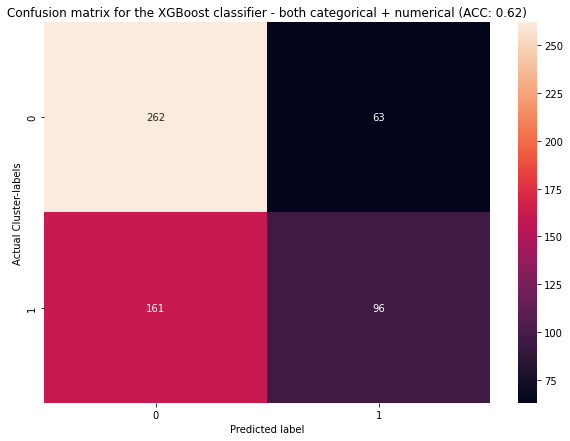

In [26]:
from sklearn.model_selection import KFold
# -	FMS, daar schat ik in dat je en hogere diagnos accuratesse kan vinden.
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import time
import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.calibration import CalibratedClassifierCV

l_questionaire = [col for col in x_train if col not in ['ZDNnummer', 'DIAG', 'VERHA','aCCP', 'RF', 'VERHA_DIAG']] # 'VERHA',   
l_verha = ['VERHA']
l_sero = ['aCCP', 'RF']


X_all = pd.DataFrame(x_train[l_questionaire]).reset_index(drop=True) # l_questionaire
X = pd.DataFrame(x_train[l_elastic]).reset_index(drop=True) 



y_ = y_train.replace({0: False, 1: True}).reset_index(drop=True) 

if TARGET == 'RA': # Rheumatoid arthritis
    y_ = x_train['DIAG']=='RA'
elif TARGET == 'FMS' : # fibromyalgia
    y_ = x_train['DIAG']=='FMS'
    
# Apply 5 fold CV
kf = KFold(n_splits=5) # 
iteration = 0
y_pred = []
y_pred_all = []
y_pred_calibrated = []

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index[:10], "TEST:", test_index[:10])
    X_train, X_test = pd.DataFrame(X).loc[train_index], pd.DataFrame(X).loc[test_index]
    X_train_all, X_test_all = pd.DataFrame(X_all).loc[train_index], pd.DataFrame(X_all).loc[test_index]
    Y_train, Y_test = np.take(y_, np.array(train_index)), np.take(y_, np.array(test_index))

    # Normalize
    fit_gaussian = False

    # Model is an XGBClassifier
    n_trees = 50
    dmat_train = xgb.DMatrix(X_train,Y_train)
    dmat_train_all = xgb.DMatrix(X_train_all,Y_train)
    dmat_test = xgb.DMatrix(X_test, Y_test)
    dmat_test_all = xgb.DMatrix(X_test_all,Y_test)

    t0 = time.time()
    
    if TARGET == 'RA':
        # Best for RA
        bst = xgb.train({'objective': "reg:squaredlogerror", 'tree_method': 'exact','booster': 'gbtree', 'lambda': 0.0006200747552600966, 'alpha': 0.0015949249869996653, 'learning_rate': 0.24119084896088652, 'subsample': 0.9764552232116535, 'colsample_bytree': 0.5240035049084266, 'max_depth': 1, 'eta': 1.1217695485633615e-06, 'gamma': 0.017575222427374252, 'grow_policy': 'lossguide'}, 
                        dmat_train,  n_trees, evals=[(dmat_train, "train"), (dmat_test, "test")])
    elif TARGET == 'FMS': 
        # BeSt wfor FMG ()
        bst = xgb.train({'objective': "reg:tweedie", 'tree_method': 'exact', 'booster': 'gbtree', 'lambda': 0.010474753425000384, 'alpha': 6.032894290859287e-08, 'learning_rate': 0.09606440973264073, 'subsample': 0.9704960938323709, 'colsample_bytree': 0.6570054417278487, 'max_depth': 3, 'eta': 1.5235407284877212e-06, 'gamma': 0.056688487256944656, 'grow_policy': 'lossguide'},
                         dmat_train,  n_trees, evals=[(dmat_train, "train"), (dmat_test, "test")])
    else: 
        #  BesT for IRD
        bst = xgb.train({'objective': "reg:squarederror", 'tree_method': 'exact', 'lambda': 0.020944160909950403, 'alpha': 4.368931912821549e-07, 'learning_rate': 0.10534170309932615, 'subsample': 0.6429343153620561, 'colsample_bytree': 0.859663368607579, 'max_depth': 3, 'eta': 4.359674416831068e-06, 'gamma': 2.0590895849808663e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0029236981053022987, 'skip_drop': 2.834081291173374e-08}
            , dmat_train,  n_trees, evals=[(dmat_train, "train"), (dmat_test, "test")])

    
    y_pred.extend(bst.predict(dmat_test))
    
    # General model ; All questions
    
    #bst_all  = xgb.train({'objective': "reg:squaredlogerror", 'tree_method': 'exact', 'booster': 'gbtree','booster': 'dart', 'lambda': 5.790932213214483e-06, 'alpha': 0.008674328425071043, 'learning_rate': 0.28996976040612077, 'subsample': 0.8402705730857806, 'colsample_bytree': 0.6614627760960018, 'max_depth': 2, 'eta': 6.560094339512443e-06, 'gamma': 1.0633231590261876e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.8291461529674531e-07, 'skip_drop': 0.020489904945851182}
     #           , dmat_train_all,  n_trees, evals=[(dmat_train_all, "train"), (dmat_test_all, "test")])
    # General model ; All questions
    bst_all  = xgb.train({'objective': "reg:squaredlogerror", 'tree_method': 'exact', 'eval_metric':'error',
                      'booster': 'gbtree', 'lambda': 0.029348611977903567, 'alpha': 0.424303014007739, 'max_depth': 3, 'eta': 0.1905227715703055, 'gamma': 0.06759427128150776, 'grow_policy': 'depthwise'}
                     , dmat_train_all,  n_trees, evals=[(dmat_train_all, "train"), (dmat_test_all, "test")]) # "tree_method": "gpu_hist", 
    y_pred_all.extend(bst_all.predict(dmat_test_all))
    
    t1 = time.time()
    print('Time for Training XGB model %s: %s' % (str(iteration+1), str(t1-t0)))
    iteration += 1
    
    
fig = plt.figure()

threshold = 0.5
cm = confusion_matrix(y_, np.array(y_pred_all)> threshold).astype('float')
accuracy = accuracy_score(y_, np.array(y_pred_all)> threshold).astype('float')

df_cm = pd.DataFrame(cm, index = list(range(len(y_.unique()))),
                  columns = list(range(len(y_.unique()))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Predicted label")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the XGBoost classifier - both categorical + numerical (ACC: %.2f)' % (accuracy))

# export model
bst.save_model('models/xgboost_bst_auc_%s_reduced.json' % TARGET)

In [34]:
#bst_all.save_model('models/xgboost_bst_auc_%s_allQuestions.json' % TARGET)

#### import functions to estimate performance

In [27]:
#import collections.OrderedDict
from collections import Counter
#from typing_extensions import OrderedDict

def sortedPredictionList(y_pred, y_test):
    """
    This function sorts the list of true labels by the
    list of predictions. The sorted list of true labels
    can be used to create a ROC-curve for a non-probability
    classifier (a.k.a. a binary classifier like decision tree).

    Input:
        b_pred = list of hard-predictions (0 or 1) 
            or probabilities (0-1)
        y_test = list of actual labels, binarized to 
            1 or 0. 

    Example for generating 'l_sorted_true':
        Before sort:
           pred: 0 1 1 0 1 0 1 0 1 1 1 0 1 0
           true: 0 1 0 0 1 0 0 1 1 0 1 0 1 1
        After sort:
           pred: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 
        -> true: 1 1 0 1 0 0 1 1 0 0 1 1 0 0

    Output:
        l_sorted_true = list of true label sorted on the 
            predictions label:
    """
    #pred, y_test = list(y_wm.astype(int)), list(y_gold)
    df_pred = pd.DataFrame(y_pred, y_test).reset_index()
    df_pred.columns = ['pred', 'true']
    df_pred = df_pred.sample(frac=1).reset_index(drop=True)
    df_pred = df_pred.sort_values(by='pred', ascending=False) #.to_csv('')
    return list(df_pred['pred']),  list(df_pred['true'])

def infer_binary(pred, y_test):
    #print(pred, y_test)
    l_pred, l_true = sortedPredictionList(pred, y_test)
    dummi = l_pred
    dummi = [2 if x==0 else x for x in dummi]
    dummi = [x -1 for x in dummi]
    l_pred.insert(0,0)
    l_true.insert(0,0)
    dummi.insert(0,0)
    # Compute basic statistics:
    TP = pd.Series(l_true).cumsum()
    FP = pd.Series(dummi).cumsum()
    P = sum(l_true)
    N = sum(dummi)
    TPR = TP.divide(P) # sensitivity / hit rate / recall
    FPR = FP.divide(N)  # fall-out
    PRC = TP.divide(TP + FP) # precision
    F1 = 2 * (PRC * TPR) / (PRC + TPR)
    d_conf = {'tpr': TPR, 'fpr': FPR, 'prc': PRC, 'threshold': l_pred, 'f1': F1}
    #d_conf = {'tpr': TPR, 'fpr': FPR, 'prc': PRC, 'threshold': l_pred}
    return d_conf

def scoresCM(CM):
    """
    Derive performance characteristics from the confusion matrix
    """
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return {'tpr': TPR, 'tnr': TNR,'ppv': PPV, 'npv': NPV, 'fpr': FPR, 'fnr' : FNR, 'fdr' : FDR, 'acc' : ACC} 

#d_conf = infer_binary(list(y_wm.astype(int)), list(y_gold))

### 3.4 Visualize ROC & PR-curve

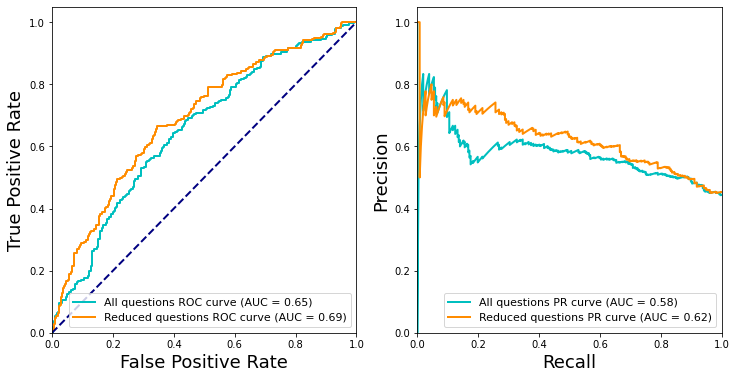

In [28]:
### import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import re

def binarize(value):
    """
    This function codifies the binary labels 'y' and 'n'
     to 1 and 0.
    """
    return int(value)



fpr, tpr, _ = roc_curve(y_, y_pred) # np.array([binarize(val) for val in y_actual])
prec, recall, _ = precision_recall_curve(y_, y_pred)

pr_auc = auc(recall, prec)
roc_auc = auc(fpr, tpr)


fig1, ax1 = plt.subplots(1,2,figsize=(12,6))

clf_name = 'XGBoost (Machine learning)'

# Validation performance
fpr_v, tpr_v, _ = roc_curve(y_, y_pred_all) # np.array([binarize(val) for val in y_actual])
prec_v, recall_v, _ = precision_recall_curve(y_, y_pred_all)

pr_auc_v = auc(recall_v, prec_v)
roc_auc_v = auc(fpr_v, tpr_v)

lw = 2

# Also plot validation
ax1[0].plot(fpr_v, tpr_v, color='c',
        lw=lw, label='%s ROC curve (AUC = %0.2f)' % ('All questions', roc_auc_v))
ax1[1].plot(recall_v, prec_v,  color='c',
        lw=lw, label='%s PR curve (AUC = %0.2f)' % ('All questions', pr_auc_v))


## ROC
ax1[0].plot(fpr, tpr, color='darkorange',
         lw=lw, label='%s ROC curve (AUC = %0.2f)' % ('Reduced questions', roc_auc))
ax1[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax1[0].set_xlim([0.0, 1.0])
ax1[0].set_ylim([0.0, 1.05])
ax1[0].set_xlabel('False Positive Rate', fontsize=18)
ax1[0].set_ylabel('True Positive Rate', fontsize=18)

ax1[0].tick_params(axis='both', which='major', labelsize=10)
ax1[0].tick_params(axis='both', which='minor', labelsize=8)

## PR
ax1[1].plot(recall, prec, color='darkorange',
         lw=lw, label='%s PR curve (AUC = %0.2f)' % ('Reduced questions', pr_auc))
ax1[1].set_xlim([0.0, 1.0])
ax1[1].set_ylim([0.0, 1.05])
ax1[1].set_xlabel('Recall', fontsize=18)
ax1[1].set_ylabel('Precision', fontsize=18)

ax1[1].tick_params(axis='both', which='major', labelsize=10)
ax1[1].tick_params(axis='both', which='minor', labelsize=8)

# Plot legend
ax1[1].legend(loc="lower right", fontsize=11)
ax1[0].legend(loc="lower right", fontsize=11)


plt.show()

### Import XGB-classifier

In [29]:
import xgboost as xgb

XGB = 1

if XGB:
    final_model = xgb.Booster()
    #final_model.load_model('models/xgboost_bst_auc_RA_backup.json')
    final_model.load_model('models/xgboost_final_IRD.json') # _wSero xgboost_bst_auc_squaredlog_backup.json
    #final_model.load_model('models/xgboost_bst_auc_squaredlog_new.json') # _wSero xgboost_bst_auc_squaredlog_backup.json

## 4 How does it perform in the hold out set?

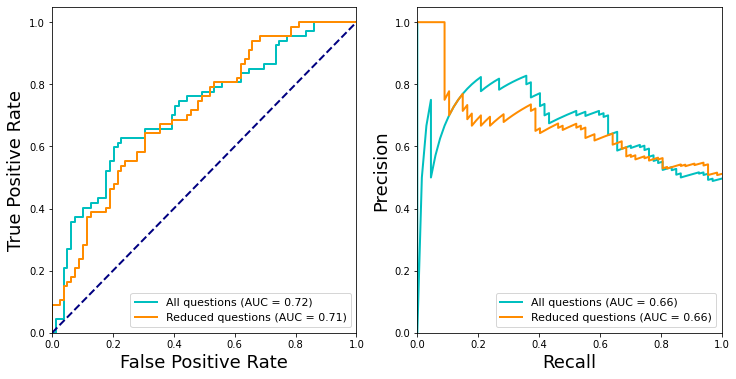

In [35]:
### import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import re

def binarize(value):
    """
    This function codifies the binary labels 'y' and 'n'
     to 1 and 0.
    """
    return int(value)


y_gold = y_test.copy() #x_test['DIAG']=='FMS'#


#y_test.replace({0: False, 1: True})
y_pred_test = final_model.predict(xgb.DMatrix(x_test[l_elastic])) # 
y_pred_test_all = bst_all.predict(xgb.DMatrix(x_test[l_questionaire])) # l_questionaire

fpr, tpr, _ = roc_curve(y_gold, y_pred_test) # np.array([binarize(val) for val in y_actual])
prec, recall, _ = precision_recall_curve(y_gold, y_pred_test)

pr_auc = auc(recall, prec)
roc_auc = auc(fpr, tpr)


fig1, ax1 = plt.subplots(1,2,figsize=(12,6))

clf_name = 'XGBoost (Machine learning)'

# Also show performance word matching
#y_wm =  ~df_test['WM'].isna()
# Use same model
lw = 2


BINARY = 0
if BINARY == 0:
    # Validation performance
    fpr_v, tpr_v, _ = roc_curve(y_gold, y_pred_test_all) # np.array([binarize(val) for val in y_actual])
    prec_v, recall_v, _ = precision_recall_curve(y_gold, y_pred_test_all)

    pr_auc_v = auc(recall_v, prec_v)
    roc_auc_v = auc(fpr_v, tpr_v)
    
    # Also plot validation
    ax1[0].plot(fpr_v, tpr_v, color='c',
            lw=lw, label='%s (AUC = %0.2f)' % ('All questions', roc_auc_v))
    ax1[1].plot(recall_v, prec_v,  color='c',
            lw=lw, label='%s (AUC = %0.2f)' % ('All questions', pr_auc_v)) 



## ROC
ax1[0].plot(fpr, tpr, color='darkorange',
         lw=lw, label='%s (AUC = %0.2f)' % ('Reduced questions', roc_auc))
ax1[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax1[0].set_xlim([0.0, 1.0])
ax1[0].set_ylim([0.0, 1.05])
ax1[0].set_xlabel('False Positive Rate', fontsize=18)
ax1[0].set_ylabel('True Positive Rate', fontsize=18)

ax1[0].tick_params(axis='both', which='major', labelsize=10)
ax1[0].tick_params(axis='both', which='minor', labelsize=8)

## PR
ax1[1].plot(recall, prec, color='darkorange',
         lw=lw, label='%s (AUC = %0.2f)' % ('Reduced questions', pr_auc))
ax1[1].set_xlim([0.0, 1.0]) 
ax1[1].set_ylim([0.0, 1.05])
ax1[1].set_xlabel('Recall', fontsize=18)
ax1[1].set_ylabel('Precision', fontsize=18)

ax1[1].tick_params(axis='both', which='major', labelsize=10)
ax1[1].tick_params(axis='both', which='minor', labelsize=8)

# Plot legend
ax1[1].legend(loc="lower right", fontsize=11)
ax1[0].legend(loc="lower right", fontsize=11)


plt.show()

### Calculate confidence interval

In [40]:
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
n_iterations = 100
auc_values = []

np.random.seed(0)
df_pred = pd.DataFrame({ 'pred' : y_pred_test, 'IRD' : y_gold})
df_pred = df_pred.reset_index(drop=True)
df_pred['Sex'] = x_train['Geslacht']
roc_auc_score(df_pred['IRD'], df_pred['pred'])

for _ in range(n_iterations):
    # Resample with replacement
    indices = np.random.choice(len(df_pred['IRD']), len(df_pred['IRD']), replace=True)
    resampled_data = df_pred.loc[indices]
    # Calculate AUC for the resampled dataset
    resampled_auc = roc_auc_score(resampled_data['IRD'], resampled_data['pred'])
    auc_values.append(resampled_auc)

# Calculate the confidence interval
confidence_interval = np.percentile(auc_values, [2.5, 97.5])

#print(f'Original AUC: {original_auc:.4f}')
print(f'95% Confidence Interval: {confidence_interval}')

95% Confidence Interval: [0.62832585 0.77590305]


Brier score: 0.22182530195503253


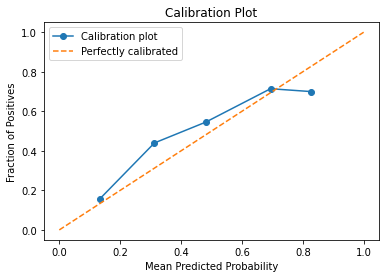

In [41]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# Create a calibration plot
df_pred.loc[df_pred['pred'] < 0, 'pred'] = 0
prob_true, prob_pred = calibration_curve(df_pred['IRD'].astype(float), df_pred['pred'], n_bins=5, strategy='uniform')
print('Brier score:', brier_score_loss(df_pred['IRD'].astype(float), df_pred['pred']))

# Plot the calibration curve
plt.plot(prob_pred, prob_true, marker='o', label='Calibration plot')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend()
plt.show()

#### Calculate CI (for full model)

In [42]:
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
n_iterations = 100
auc_values = []

np.random.seed(0)
df_pred = pd.DataFrame({ 'pred' : y_pred_all, 'IRD' : y_})
df_pred = df_pred.reset_index(drop=True)
roc_auc_score(df_pred['IRD'], df_pred['pred'])

for _ in range(n_iterations):
    # Resample with replacement
    indices = np.random.choice(len(df_pred['IRD']), len(df_pred['IRD']), replace=True)
    resampled_data = df_pred.loc[indices]
    # Calculate AUC for the resampled dataset
    resampled_auc = roc_auc_score(resampled_data['IRD'], resampled_data['pred'])
    auc_values.append(resampled_auc)

# Calculate the confidence interval
confidence_interval = np.percentile(auc_values, [2.5, 97.5])

#print(f'Original AUC: {original_auc:.4f}')
print(f'95% Confidence Interval: {confidence_interval}')

95% Confidence Interval: [0.6104027  0.70435576]


## 5. Downstream analysis

### 5.1 elucidate key features
Conduct a SHAP analysis

In [62]:
import shap

N_FEAT = 15
t0 = time.time()
t_explainer = shap.TreeExplainer(final_model, feature_names=[inverted_dict[x] for x in l_elastic]) # or just X? ,  feature_names=tfidf_feature_names
shap_values = t_explainer( x_train[l_elastic], y_train)
t1 = time.time()
print('Calculating SHAP: ' + str(t1-t0))

Calculating SHAP: 0.013407230377197266


In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  
shap_values.feature_names = [inverted_dict[x] for x in l_elastic]
shap.plots.beeswarm(shap_values, max_display=20, show=False)

plt.savefig('figures/shap_top%s_%s_new.png' % (str(N_FEAT), TARGET), dpi=100, bbox_inches='tight')
# Save the figure
plt.close()  # Close the figure to prevent displaying again
plt.clf()

<Figure size 432x288 with 0 Axes>

### Calculate confidence interval of validation set

In [65]:
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
n_iterations = 100
auc_values = []

np.random.seed(0)
df_pred = pd.DataFrame({ 'pred' : y_pred_test, 'IRD' : y_gold, 'DIAG': x_test['DIAG']})
df_pred = df_pred.reset_index(drop=True)
roc_auc_score(df_pred['IRD'], df_pred['pred'])

for _ in range(n_iterations):
    # Resample with replacement
    indices = np.random.choice(len(df_pred['IRD']), len(df_pred['IRD']), replace=True)
    resampled_data = df_pred.loc[indices]
    # Calculate AUC for the resampled dataset
    resampled_auc = roc_auc_score(resampled_data['IRD'], resampled_data['pred'])
    auc_values.append(resampled_auc)

# Calculate the confidence interval
confidence_interval = np.percentile(auc_values, [2.5, 97.5])

#print(f'Original AUC: {original_auc:.4f}')
print(f'95% Confidence Interval: {confidence_interval}')

95% Confidence Interval: [0.54843292 0.77180572]


#### CI of full model (all questions in validation)

In [66]:
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
n_iterations = 100
auc_values = []

np.random.seed(0)
df_pred = pd.DataFrame({ 'pred' : y_pred_test, 'IRD' : y_gold, 'DIAG': x_test['DIAG'], 'Sex': x_test['Geslacht']})
df_pred = df_pred.reset_index(drop=True)
roc_auc_score(df_pred['IRD'], df_pred['pred'])

for _ in range(n_iterations):
    # Resample with replacement
    indices = np.random.choice(len(df_pred['IRD']), len(df_pred['IRD']), replace=True)
    resampled_data = df_pred.loc[indices]
    # Calculate AUC for the resampled dataset
    resampled_auc = roc_auc_score(resampled_data['IRD'], resampled_data['pred'])
    auc_values.append(resampled_auc)

# Calculate the confidence interval
confidence_interval = np.percentile(auc_values, [2.5, 97.5])

#print(f'Original AUC: {original_auc:.4f}')
print(f'95% Confidence Interval: {confidence_interval}')

95% Confidence Interval: [0.54843292 0.77180572]


### 5.2 Cut-off analysis

/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning:

51.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning:

38.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



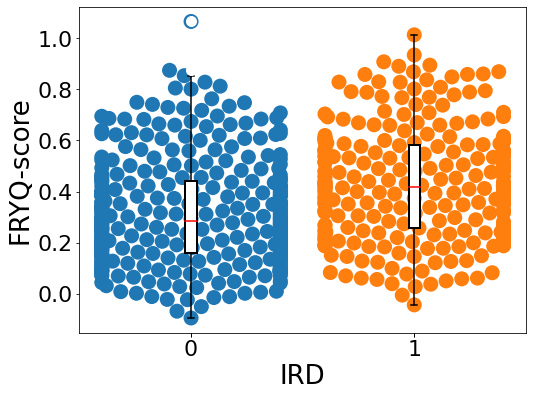

In [43]:
import seaborn as sns
params = {'legend.fontsize': 10,
          'figure.figsize': (8,6),
          'axes.grid': False,
         'axes.labelsize': 26,
         'axes.titlesize':'xx-small',
         'xtick.labelsize':22,
          'axes.labelcolor' : 'k',
          'ytick.color' : 'k',
          'xtick.color': 'k',
        'font.weight':'regular',
         'ytick.labelsize':22}
plt.rcParams.update(params)

# Create a violin plot
fig, ax = plt.subplots()

# Create a violin plot
sns.swarmplot(x="IRD", y="pred", ax=ax, data=df_pred, zorder=0, size=15)

for category in [0, 1]:
    subset = df_pred[df_pred['IRD'] == category]['pred']
    ax.boxplot(subset, positions=[category], widths=0.05, patch_artist=True, boxprops=dict(color='black', facecolor='white', linewidth=2), 
               medianprops=dict(color='red', linewidth=1.5), whiskerprops=dict(color='black', linewidth=1.5), capprops=dict(color='black', linewidth=1.5), 
               flierprops=dict(markerfacecolor='white', marker='o', markersize=10, linestyle='none',  linewidth=2, markeredgecolor='white'))
ax.set_ylabel('FRYQ-score')
# Show the plot
plt.show()

In [44]:
def scoresCM(CM):
    """
    Derive performance characteristics from the confusion matrix
    """
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return {'tpr': TPR, 'tnr': TNR,'ppv': PPV, 'npv': NPV, 'fpr': FPR, 'fnr' : FNR, 'fdr' : FDR, 'acc' : ACC} 



for i in np.arange(0.09, 0.40, 0.01):
    cm = confusion_matrix(y_gold.astype(int), np.array(y_pred_test) > i).astype('float')
    d_scores = scoresCM(cm)
    print('Thresh=%.2f \t' % i + '; '.join(['%s = %.2f' % (k, d_scores[k]) for k in d_scores.keys()]))

Thresh=0.09 	tpr = 1.00; tnr = 0.09; ppv = 0.48; npv = 1.00; fpr = 0.91; fnr = 0.00; fdr = 0.52; acc = 0.51
Thresh=0.10 	tpr = 1.00; tnr = 0.09; ppv = 0.48; npv = 1.00; fpr = 0.91; fnr = 0.00; fdr = 0.52; acc = 0.51
Thresh=0.11 	tpr = 1.00; tnr = 0.10; ppv = 0.49; npv = 1.00; fpr = 0.90; fnr = 0.00; fdr = 0.51; acc = 0.51
Thresh=0.12 	tpr = 1.00; tnr = 0.11; ppv = 0.49; npv = 1.00; fpr = 0.89; fnr = 0.00; fdr = 0.51; acc = 0.52
Thresh=0.13 	tpr = 1.00; tnr = 0.14; ppv = 0.50; npv = 1.00; fpr = 0.86; fnr = 0.00; fdr = 0.50; acc = 0.53
Thresh=0.14 	tpr = 1.00; tnr = 0.19; ppv = 0.51; npv = 1.00; fpr = 0.81; fnr = 0.00; fdr = 0.49; acc = 0.56
Thresh=0.15 	tpr = 0.99; tnr = 0.19; ppv = 0.51; npv = 0.94; fpr = 0.81; fnr = 0.01; fdr = 0.49; acc = 0.55
Thresh=0.16 	tpr = 0.96; tnr = 0.22; ppv = 0.51; npv = 0.85; fpr = 0.78; fnr = 0.04; fdr = 0.49; acc = 0.55
Thresh=0.17 	tpr = 0.96; tnr = 0.28; ppv = 0.53; npv = 0.88; fpr = 0.72; fnr = 0.04; fdr = 0.47; acc = 0.59
Thresh=0.18 	tpr = 0.96; tnr

t-statistic: 4.5746027244050556, p-value: 1.0206694894958815e-05


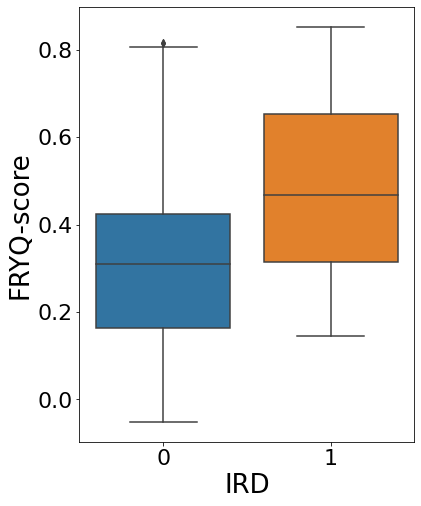

In [45]:
import seaborn as sns
from scipy.stats import ttest_ind

plt.figure(figsize=(6,8))
df_pred = pd.DataFrame({ 'pred' : y_pred_test, 'IRD' : y_gold, 'DIAG': x_test['DIAG'], 'Sex': x_test['Geslacht']})
#df_pred = pd.DataFrame(y_pred_test_all, columns=['pred'] )
#df_pred['IRD'] = y_gold.astype(int)
#df_pred['Sex'] = x_test['Geslacht'].astype(int)
#df_pred.boxplot(by='RA')
# Create a violin plot
sns.boxplot(x="IRD", y="pred", data=df_pred)

# Perform t-test
stat, p_value = ttest_ind(df_pred[df_pred['IRD']==1]['pred'], df_pred[df_pred['IRD']==0]['pred'])

print(f"t-statistic: {stat}, p-value: {p_value}")

# Show the plot
plt.ylabel('FRYQ-score')
plt.show()

### 5.3 Show FRYQ-scores per disease

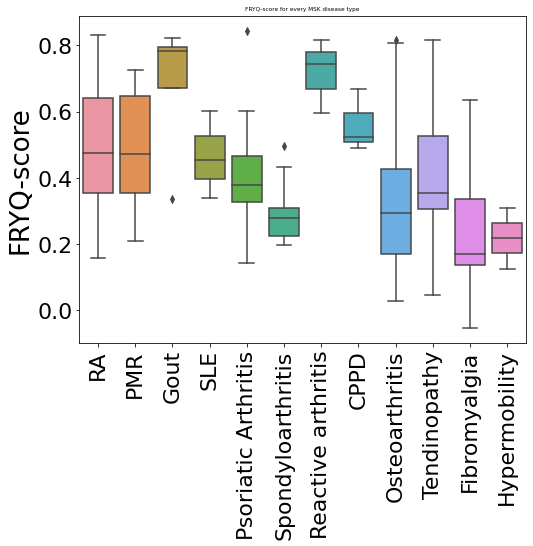

In [46]:
l_order = ['RA', 
 'PMR',
 'Gout',
 'SLE',
 'Psoriatic Arthritis',
 'Spondyloarthritis',
 #'Sjogren disease',
 'Reactive arthritis',
 #'undifferentiated arthritis',
 #'Systemic sclerosis',
 'CPPD',
 #'Probable RMD in development',
 #'Sarcoidosis',
 
 'Osteoarthritis',
 'Tendinopathy',
 'Fibromyalgia',
 'Hypermobility',
 ]

# Create boxplot with Seaborn
plt.figure(figsize=(8, 6))

df_pred['DIAG_form'] = df_pred['DIAG'].apply(lambda x : d_final_labels[x]) # d_IRD_GP
sns.boxplot(data=df_pred, x='DIAG_form', y='pred', order = l_order) #  order = l_order
plt.title('FRYQ-score for every MSK disease type')
plt.xlabel('')
plt.ylabel('FRYQ-score')
# Rotate x-axis labels
plt.xticks(rotation=90)
plt.show()

# 6. Replication 

## 6.1 Load model

In [47]:
import xgboost as xgb

XGB = 1

if XGB:
    final_model = xgb.Booster()

    final_model.load_model('models/xgboost_final_IRD.json')

## 6.2 preprocess replication data

In [48]:
import pandas as pd
import numpy as np 

file_name = 'data/FRYQZOHOuitdraai11MAR24_zonderTestpersonen.txt'
df_jpast = pd.read_csv(file_name, sep='\t')

# df_zoho = pd.read_csv('FRYQ_ZOHO_Uitdraai_11MAR2024.csv', sep=';')
df_zoho = pd.read_spss('data/FRYQZOHOUitdraai_16AUG2024.sav')
df_jpast['Toegangscode'] = df_jpast['Toegangscode'].replace('Toegangscode: 428623000004284001', '428623000004284001').replace('JVGL06289524000842590688.', '428623000003968043').replace(':%20428623000003866131', '428623000003866131')
df_zoho['Toegangscode'] = df_zoho['Toegangscode'].str.replace('"', '')# ('"5672417', '5672417').replace('"428623000003415046', '428623000003415046').replace('"428623000001053148', '428623000001053148')

df_jpast= df_jpast[~df_jpast['Toegangscode'].isin(['as.bergsma'])]
df_jpast['Toegangscode'] = df_jpast['Toegangscode'].astype(float)
df_zoho['Toegangscode']= df_zoho['Toegangscode'].astype(float)

d_diag_zoho = dict(zip(df_zoho['Email'], df_zoho['diagnosecode']))
d_sex_zoho = dict(zip(df_zoho['Email'], df_zoho['Geslacht']))

df_jpast['diagnosecode'] = df_jpast['E-mail'].apply(lambda x : d_diag_zoho[x] if x in d_diag_zoho.keys() else np.nan)
df_jpast['Geslacht'] = df_jpast['E-mail'].apply(lambda x : d_sex_zoho[x] if x in d_sex_zoho.keys() else np.nan)
df_jpast['Geslacht'] = df_jpast['Geslacht'].replace({'M' : 0.0, 'F' : 1.0, 'V': 1.0, '?' : np.nan}) #
df_jpast['Geslacht'] = df_jpast['Geslacht'].astype(float)
df_jpast['diagnosecode'].unique()

# Categorize diagnoses into higher disease codes
df_jpast['Category'] = df_jpast['diagnosecode'].map(d_groups_old)
#d_category_repl = dict(zip(df_jpast['Toegangscode'], df_jpast['Category']))
#df_jpast['Category']
print("Total entries: ", len(df_jpast['E-mail']))
print("Unique identifiers (emails): ", len(df_jpast['E-mail'].unique()))
print("Labelled unique entries (Diagnose) ", len(df_jpast[~df_jpast['Category'].isna()]['E-mail'].unique()))
print("Labelled unique entries w Geslacht", len(df_jpast[((~df_jpast['Category'].isna()) & (~df_jpast['Geslacht'].isna()))]['E-mail'].unique()))
#df_jpast['diagnosecode'] = df_jpast['diagnosecode'].apply(lambda x : d_category[x] if x in d_category.keys() else np.nan) 

Total entries:  561
Unique identifiers (emails):  552
Labelled unique entries (Diagnose)  508
Labelled unique entries w Geslacht 507


## 6.3 show disease prevalence in replication set

(76, 55, 37, 33, 105, 99, 7, 18, 16, 23, 17, 1, 23, 2, 8, 6, 7, 8, 4, 7, 4, 5)


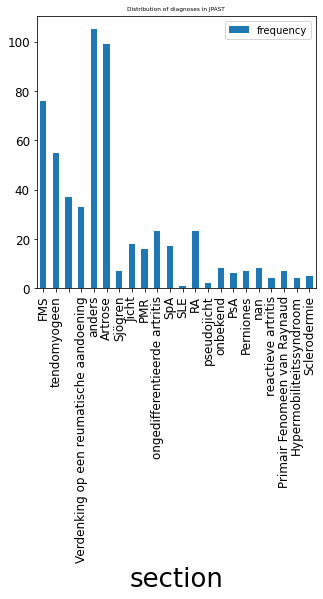

In [49]:
import matplotlib.pyplot as plt
from collections import Counter

labels, values = zip(*Counter(df_jpast['diagnosecode']).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Distribution of diagnoses in JPAST", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=90)
plt.show()

(248, 155, 113)


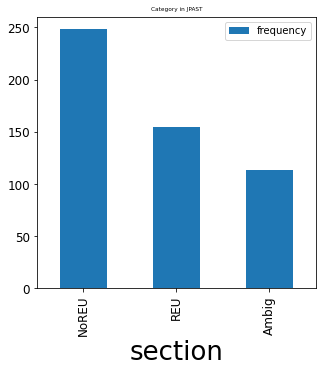

In [50]:
labels, values = zip(*Counter(df_jpast[df_jpast['Category'].isin(['NoREU', 'REU', 'Ambig'])]['Category']).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Category in JPAST", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=90)
plt.show()

# 862 - 726

## 6.4 Encode FRYQ answers
Align new questions (JPAST) to old questions (ZDC)

In [51]:
import pandas as pd
df_diag = pd.read_csv('suppl/20240314_diagnosis_jpast_renny_RK.csv', sep=';')
#df_diag

In [52]:
d_mapping_questions =  { 
 '1.1 Ik word ‘s nachts wakker van de pijn' : 'v1.1',
 '1.2 Ik word vooral tegen de ochtend wakker van de pijn' : 'v1.2',
 '1.3 De pijn is de hele dag aanwezig' : 'v1.3',
 '1.4 De pijn wordt beter bij bewegen' : 'v1.4',
 '1.5 De pijn wordt beter door rust'  : 'v1.5',
 '1.6 Bij geringe aanraking is het al heel pijnlijk'  : 'v1.6',
 '1.7 Na aanraken houdt de pijn nog meer dan een half uur aan': 'v1.7',
 '1.8 Bij stoten is de plek pijnlijk': 'v1.8',
 '1.9 Bij omdraaien in bed heb ik pijn aan de buitenkant van mijn heupen': 'v1.9',
 '1.10 Ik heb pijn sinds:': 'v1.10',
 '1.11 Een ontstekingsremmer als ibuprofen of diclofenac helpt goed': 'v1.11',
 '2.1 De stijfheid is vooral in de ochtend' : 'v2.1',
 '2.2 De stijfheid is vooral na rust' : 'v2.2',
 '2.3 De stijfheid duurt minder dan 30 minuten na het wakker worden' : 'v2.3',
 '2.4 De stijfheid duurt langer dan 45 minuten na het wakker worden' : 'v2.4',
 '2.5 De stijfheid wordt beter na rust' : 'v2.5',
 '2.6 De stijfheid wordt beter bij bewegen'  : 'v2.6',
 '2.7 De stijfheid is acuut ontstaan en zit vooral in schouders en heupen' : 'v2.7',
 '2.8 Ik heb stijfheid sinds:' : 'v2.8',
 '2.9 Een ontstekingsremmer als ibuprofen of diclofenac helpt goed'  : 'v2.9',
 '3. Door mijn klachten:' : 'v3ab',
 '3. Door mijn klachten: (De somberheid was voor de klachten niet aanwezig)' : 'v3.6',
 '4.1 Ik heb last van psoriasis' : 'v6.1',
 '4.2 Ik heb last van Colitis ulcerosa/De ziekte van Crohn (ontstekingen in de darmen)'  : 'v6.2',
 '4.3 Ik heb last van oogontstekingen' : 'v6.3',
 '4.4 Ik heb last van Fenomeen van Raynaud (vingertoppen worden bij kou pijnlijk en wit/ blauw en kleuren weer rood bij)' : 'v6.4',
 '4.5 Ik heb last van Sarcoïdose' : 'v6.5',
 '4.6 Ik heb last van zonneallergie (jeuk/bultjes op de huid waarop de zon heeft geschenen)' : 'v6.6',
 '4.7 Ik heb last van droge ogen/mond' : 'v6.7',
 '4.8 Ik heb last van eten dat niet wil zakken (in de slokdarm)' :  'v6.8',
 #'4.9 Ik heb last van aften/blaren in de mond' :  'v6.9',
 #'4.10 Ik heb last van koorts' :  'v6.10',
 #'4.11.1 Hoeveel ben u afgevallen?' :  'v6.11',
 '4.12 Ik heb last van pijn op de borst' :  'v6.12',
 '4.13 Ik heb last van kortademigheidsklachten' :  'v6.13',
 '4.15 Ik heb last van een veranderd ontlastingspatroon' :  'v6.11',
 '5.1 Ik heb zwaar werk' : 'v7.1',
 '5.2 Ik doe thuis het huishouden'  : 'v7.2',
 '5.3 Ik kan mijn werk uitvoeren zoals ik wil'  : 'v7.3',
 "5.4 Ik kan mijn hobby's uitvoeren zoals ik wil" : 'v7.4',
 '5.5 Ik kan mijn huishouden uitvoeren zoals ik wil' : 'v7.5',
 '5.6 Ik was heel lenig'  : 'v7.6',
 '5.7 Ik ben nog steeds heel lenig' : 'v7.7',
 '5.8 Ik kan ’s nachts goed slapen' : 'v7.8',
 '5.9 Ik word bijna nooit moe wakker' : 'v7.9',
 '5.10 Overdag wil ik het liefste nog een dutje doen' : 'v7.10',
 '5.11 Ik kan geen “nee” zeggen als iemand mij om een gunst vraagt'  : 'v7.11',
 '5.12 Ik weet goed wat ik kan en wat ik niet kan' : 'v7.12',
 '5.13 Ik ga bijna nooit over mijn grenzen heen' : 'v7.13',
 '5.14 Ik heb een hoge pijngrens' : 'v7.14',
 '5.15 Ik sta altijd voor anderen klaar' : 'v7.15',
 '5.16 Ik heb nog voldoende tijd voor mezelf (bv hobby’s)' : 'v7.16',
 '5.17 Ik ben perfectionistisch' : 'v7.17',
 '6.1 Pijn zoals die afgelopen week was' : 'v8.1',
 '6.2 Ik voel me over het algemeen:' : 'v8.2',
 '6.3 Moeheid:' : 'v8.3',
 '7.1 Komen er in de familie ziekten/aandoeningen voor zoals reumatische aandoeningen? Zo ja, welke aandoening en bij wie?'  : 'v9.1',
 '7.2 Kunt u aangeven wat er is gebeurd met u of in uw omgeving voordat de klachten begonnen?'  : 'v9.2',
 '7.3 Kunt u iets vertellen over uw huidige/voorgaande werk?'  : 'v9.3',
 '7.4 Kunt u iets vertellen over uw hobby’s/werkzaamheden?'  : 'v9.4',
 '7.5 Kunt u iets vertellen over uw gezinssamenstelling?'  : 'v9.5',
 '7.6 Wat denkt u zelf dat er aan de hand is?'  : 'v9.6',
 '7.7 Maakt u zich ergens zorgen over? Indien ja, zo mogelijk nader specificeren.'   : 'v9.7',
 '7.8 Zijn er elders al onderzoeken verricht? Zo ja, welke en waar? Weet u ook de uitkomst? Zo ja, welke was dat?' : 'v9.8',
 '7.9 Gebruikt u hulpmiddelen, ter verbetering van de klachten dan wel om u zelf te kunnen redden met dagelijkse bezigheden? Zo ja, welke hulpmiddelen?' : 'v9.9',
 'Geslacht' : 'Geslacht'

}
# Define list of questions
l_questions = ['v1.1', 'v1.2', 'v1.3', 'v1.4', 'v1.5', 'v1.6', 'v1.7', 'v1.8', 'v1.9', 'v1.10', 'v1.11', 'v2.1', 'v2.2', 'v2.3', 'v2.4', 'v2.5', 'v2.6', 'v2.7', 'v2.8', 'v2.9', 'v3.1', 'v3.2', 'v3.3', 'v3.4', 'v3.5', 'v3.6', 'v5ab', 'v5.1', 'v5.2', 'v5.3', 'v5.4', 'v5.5', 'v5.6', 'v6.1', 'v6.2', 'v6.3', 'v6.4', 'v6.5', 'v6.6', 'v6.7', 'v6.8', 'v6.9', 'v6.10', 'v7.1', 'v7.2', 'v7.3', 'v7.4', 'v7.5', 'v7.6', 'v7.7', 'v7.8', 'v7.9', 'v7.10', 'v7.11', 'v7.12', 'v7.13', 'v7.14', 'v7.15', 'v7.16', 'v7.17', 'v8.1', 'v8.2', 'v8.3']

df_jpast = df_jpast.rename(columns = d_mapping_questions)
inverted_dict = {value: key for key, value in d_mapping_questions.items()}


#### 6.4.1 Decode question 3

In [53]:
def unwrap_q3(answer): 
    s_func = str('Functioneer ik minder goed in mijn werk' in answer)
    s_ill = str('Heb ik mij ziek gemeld op het werk' in answer)
    s_hobby = str('Kan ik mijn hobby’s minder goed uitvoeren' in answer)
    s_house = str('Kan ik minder goed mijn huishouden doen' in answer)
    s_gloomy = str('Ben ik somber' in answer)
    s_order = str('De somberheid was voor de klachten niet aanwezig' in answer)
    return s_func,s_ill, s_hobby, s_house, s_gloomy, s_order

df_jpast['v3ab'] = df_jpast['v3ab'].fillna('')
df_jpast['v3.1'], df_jpast['v3.2'], df_jpast['v3.3'], df_jpast['v3.4'], df_jpast['v3.5'], df_jpast['v3.6'] = zip(*df_jpast['v3ab'].apply(lambda x : unwrap_q3(x)))
df_jpast = df_jpast.rename(columns = {'studienummer' : 'ZDNnummer'})
#df_jpast

#### 6.4.2 Decode question 6.1 - 6.6

In [54]:
d_specialist = {'v6.1': '4.1.1 Ik ben hiervoor onder behandeling van de dermatoloog/huisarts', 
                'v6.2': '4.2.1 Ik ben hiervoor onder behandeling van de MDL-arts/internist',
                'v6.3': '4.3.1 Ik ben hiervoor onder behandeling van de oogarts/huisarts', 
                'v6.4': '4.4.1 Ik ben hiervoor onder behandeling van de dermatoloog/huisarts',
                'v6.5': '4.5.1 Ik ben hiervoor onder behandeling van de longarts (of een andere specialist/huisarts)',
                'v6.6': '4.6.1 Ik ben hiervoor onder behandeling van de dermatoloog/huisarts'}

def add_specialist(column):
    l_column = []
    for x in column:
        if x == x : 
            if x == 'Eens':
                new_x = ' en onder controle'
            else :
                new_x = ''
        else :
            new_x = ''
        l_column.append(new_x)
    return l_column

l_questions_specialist = d_specialist.keys()

for q in l_questions_specialist :
    df_jpast[q] = df_jpast[q] + add_specialist(df_jpast[d_specialist[q]])
    print(q, df_jpast[q].unique())
#df_jpast[l_questions_specialist]    

v6.1 ['Oneens' 'Eens' 'Eens en onder controle']
v6.2 ['Oneens' 'Eens en onder controle' 'Eens']
v6.3 ['Oneens' 'Eens en onder controle' 'Eens']
v6.4 ['Oneens' 'Eens' 'Eens en onder controle']
v6.5 ['Oneens' 'Eens' 'Eens en onder controle']
v6.6 ['Oneens' 'Eens' 'Eens en onder controle']


#### 6.4.3 Decode question 6.12 (pain in breast)

In [55]:
d_translate_breast = {'Oneens' : 'nee', 'Eensdrukkend gevoelOneens' : 'ja, vooral drukkend gevoel', 'Eensdrukkend gevoel' : 'ja, vooral drukkend gevoel' , 'Eensbij inspanning' : 'ja, bij inspanning', 'EensOneensbij inspanning': 'ja, bij inspanning', 'Eensdrukkend gevoelbij inspanning' : 'ja, drukkend gevoel bij inspanning', 'Eens' : 'ja', 'EensOneensOneens' : 'ja maar geen van beiden' }

def infer_exercise(column):
    l_column = []
    for x in column:
        if x == x : 
            if x == 'Eens':
                new_x = 'bij inspanning'
            elif x == 'Oneens' :
                new_x = 'Oneens'
            else :
                new_x = ''
                
        else :
            new_x = ''
        l_column.append(new_x)
    return l_column

def infer_pressure(column):
    l_column = []
    for x in column:
        if x == x : 
            if x == 'Eens':
                new_x = 'drukkend gevoel'
            elif x == 'Oneens' :
                new_x = 'Oneens'    
            else :
                new_x = ''
        else :
            new_x = ''
        l_column.append(new_x)
    return l_column

test = df_jpast['v6.12'] + infer_pressure(df_jpast['4.12.2 Dit is vooral een drukkend gevoel'])  + infer_exercise(df_jpast['4.12.1 Dit is vooral bij inspanning']) 
df_jpast['v6.12']  = test.replace(d_translate_breast)
df_jpast['v6.12'].unique()

array(['nee', 'ja maar geen van beiden',
       'ja, drukkend gevoel bij inspanning', 'ja, vooral drukkend gevoel',
       'ja, bij inspanning'], dtype=object)

#### 6.4.4 Decode question 6.13 (short breath) 

In [56]:
d_translate_breath = {'Oneens' : 'nee', 'EensOneensbij plat liggen' : 'ja, vooral bij plat liggen' , 'Eensbij inspanningOneens' : 'ja, vooral bij inspanning', 'Eensbij inspanningbij plat liggen' :  'ja, zowel bij inspanning als bij plat liggen', 'Eens' : 'ja', 'EensOneensOneens':  'ja'}
# warning in original zdc : hebben we een extra antwoord mogelijkheid (we hebben zowel ja, als ja, maar geen van beide )
def infer_exercise(column):
    l_column = []
    for x in column:
        if x == x : 
            if x == 'Eens':
                new_x = 'bij inspanning'
            elif x == 'Oneens' :
                new_x = 'Oneens'
            else :
                new_x = ''
        else :
            new_x = ''
        l_column.append(new_x)
    return l_column

def infer_laying(column):
    l_column = []
    for x in column:
        if x == x : 
            if x == 'Eens':
                new_x = 'bij plat liggen'
            elif x == 'Oneens' :
                new_x = 'Oneens'
            else :
                new_x = ''
        else :
            new_x = ''
        l_column.append(new_x)
    return l_column

test = df_jpast['v6.13'] + infer_exercise(df_jpast['4.13.1 De kortademigheid treedt vooral op bij inspanning'])  + infer_laying(df_jpast['4.13.2 De kortademigheid treedt vooral op bij plat liggen']) 
df_jpast['v6.13'] = test.replace(d_translate_breath)#.unique()
df_jpast['v6.13'].unique()


array(['ja, vooral bij inspanning', 'nee',
       'ja, zowel bij inspanning als bij plat liggen', 'ja',
       'ja, vooral bij plat liggen'], dtype=object)

In [57]:
l_quest = ['Index', 'v1.1', 'v1.2', 'v1.3', 'v1.4', 'v1.5', 'v1.6', 'v1.7', 'v1.8', 'v1.9', 'v1.10', 'v1.11', 'v2.1', 'v2.2', 'v2.3', 'v2.4', 'v2.5', 'v2.6', 'v2.7', 'v2.8', 'v2.9', 'v3.1', 'v3.2', 'v3.3', 'v3.4', 'v3.5', 'v3.6', 
           'v6.1', 'v6.2', 'v6.3', 'v6.4', 'v6.5', 'v6.6', 'v6.7', 'v6.8', 'v6.12', 'v6.13', 'v7.1', 'v7.2', 'v7.3', 'v7.4', 'v7.5', 'v7.6', 'v7.7', 'v7.8', 'v7.9', 'v7.10', 'v7.11', 'v7.12', 'v7.13', 'v7.14', 'v7.15', 'v7.16', 'v7.17', 'v8.1', 'v8.2', 'v8.3']

#### 6.4.5 standardize replication set

In [58]:
df_procpast = encoding_fryq(df_jpast, l_quest)

In [59]:
# Encode labels as binary
def encode_binary(y): 
    if y == 'REU': # or y =='Ambig':
        return 1
    elif y == 'NoREU' or y == 'Ambig':
        return 0
    else:
        return np.nan
    
df_procpast['Diagnose'] = df_procpast['Category'].apply(lambda x : encode_binary(x))
df_procpast['Index'] = pd.Series(df_procpast.index)

In [60]:
print('Total Pts: \t\t', len(df_procpast))
print('Pt with diagnosis: \t', len(df_procpast[~df_procpast['Category'].isna()]))
print('Pt without diagnosis:\t', len(df_procpast[df_procpast['Category'].isna()])) #'Diagnose'].unique()

Total Pts: 		 561
Pt with diagnosis: 	 516
Pt without diagnosis:	 45


#### 6.4.6 Only select patients with complete data 

In [61]:
len(df_procpast[~df_procpast['Diagnose'].isna()].dropna(subset=l_quest))

350

In [62]:
l_replication = ['Index', 'Diagnose']
l_replication.extend(l_quest)

df_repl = df_procpast[~df_procpast['Diagnose'].isna()].dropna(subset=l_quest)
df_repl = df_repl.reset_index(drop=True)
df_repl['DIAG'] = df_repl['diagnosecode']

<AxesSubplot:>

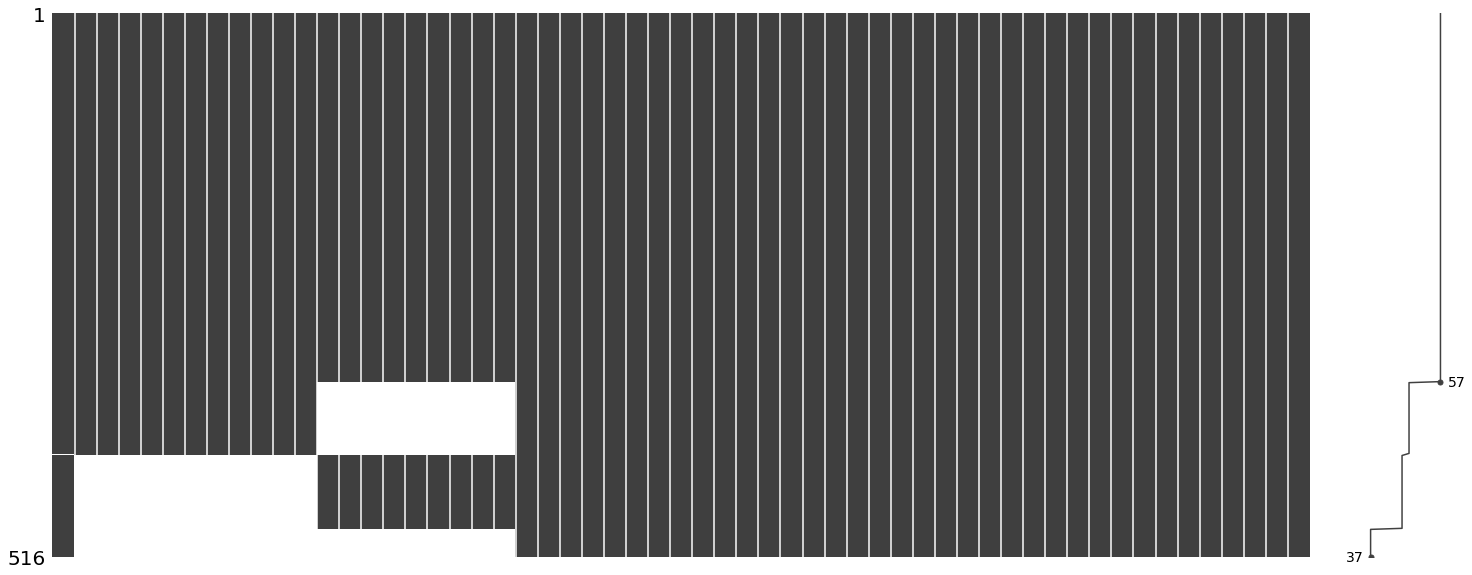

In [63]:
import missingno as msno
    
%matplotlib inline

df_procpast['Missingess'] = df_procpast[l_quest].isna().sum(axis=1)
# Sort the DataFrame by the 'Missingness' column


msno.matrix(df_procpast[~df_procpast['Diagnose'].isna()].sort_values(by='Missingess')[l_quest]) # check if patients that miss variables across lines -> have aCCP / RF of 2


In [64]:
print('patients with complete questionaire filled out:', len(df_repl))

patients with complete questionaire filled out: 350


In [65]:
print('Sex prevalence  W:', len(df_repl.dropna(subset=l_quest)[df_repl.dropna(subset=l_quest)['Geslacht']==1]), '; M:', len(df_repl.dropna(subset=l_quest)[df_repl.dropna(subset=l_quest)['Geslacht']==0]))

Sex prevalence  W: 244 ; M: 106


## 6.5 Visualize ROC & PR curve in replication cohort
How does it perform in replication data? (JPAST cohort)

In [66]:
import numpy as np

def binarize(value):
    """
    This function codifies the binary labels 'y' and 'n'
     to 1 and 0.
    """
    return int(value)

# Encode labels as binary
def encode_binary_repl(y): 
    if y == 1:
        return 1
    else:
        return 0
    

TARGET = 'IRD'

if TARGET == 'FMS':
    y_label = df_repl['DIAG']=='FMS' 
elif TARGET == 'RA':
    y_label = df_repl['DIAG']=='RA' 
else : 
    y_label = df_repl['Diagnose']
y_pred_gold_all = bst_all.predict(xgb.DMatrix(df_repl[l_questionaire])) # 
y_pred_gold = final_model.predict(xgb.DMatrix(df_repl[l_elastic])) # 
#y_pred_gold_all = bst_all.predict(xgb.DMatrix(df_repl[l_questionaire])) # 
y_granular_diag = df_repl['diagnosecode'].copy()

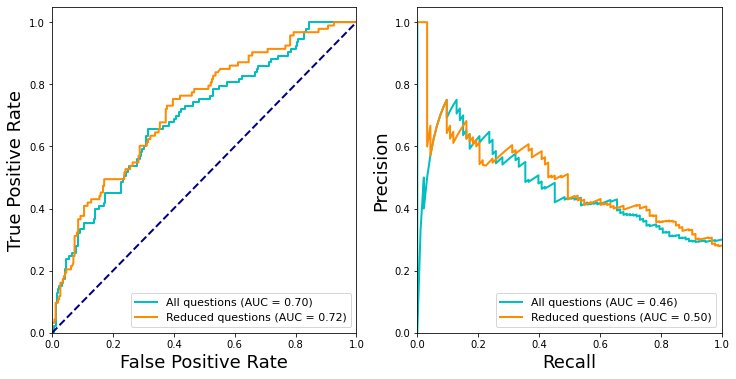

In [67]:
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def binarize(value):
    """
    This function codifies the binary labels 'y' and 'n'
     to 1 and 0.
    """
    return int(value)

# Use same model
fpr, tpr, _ = roc_curve(y_label, y_pred_gold) # np.array([binarize(val) for val in y_actual])
prec, recall, _ = precision_recall_curve(y_label, y_pred_gold)

pr_auc = auc(recall, prec)
roc_auc = auc(fpr, tpr)

fig1, ax1 = plt.subplots(1,2,figsize=(12,6))

clf_name = 'XGBoost (Machine learning)'

# now full model
fpr_ga, tpr_ga, _ = roc_curve(y_label, y_pred_gold_all) # np.array([binarize(val) for val in y_actual])
prec_ga, recall_ga, _ = precision_recall_curve(y_label,y_pred_gold_all) # y_pred_gold_all)

pr_auc_ga = auc(recall_ga, prec_ga)
roc_auc_ga = auc(fpr_ga, tpr_ga)


# Word matching (dummy classifier)
#d_conf = infer_binary(list(y_pred_test_all), list(y_gold))

lw = 2


# Also plot validation
ax1[0].plot(fpr_ga, tpr_ga, color='c',
        lw=lw, label='%s (AUC = %0.2f)' % ('All questions', roc_auc_ga))
ax1[1].plot(recall_ga, prec_ga,  color='c',
        lw=lw, label='%s (AUC = %0.2f)' % ('All questions', pr_auc_ga))

## ROC
ax1[0].plot(fpr, tpr, color='darkorange',
         lw=lw, label='%s (AUC = %0.2f)' % ('Reduced questions', roc_auc))
ax1[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax1[0].set_xlim([0.0, 1.0])
ax1[0].set_ylim([0.0, 1.05])
ax1[0].set_xlabel('False Positive Rate', fontsize=18)
ax1[0].set_ylabel('True Positive Rate', fontsize=18)
ax1[0].legend(loc="lower right", fontsize=11)
ax1[0].tick_params(axis='both', which='major', labelsize=10)
ax1[0].tick_params(axis='both', which='minor', labelsize=8)

## PR
ax1[1].plot(recall, prec, color='darkorange',
         lw=lw, label='%s (AUC = %0.2f)' % ('Reduced questions', pr_auc))
ax1[1].set_xlim([0.0, 1.0])
ax1[1].set_ylim([0.0, 1.05])
ax1[1].set_xlabel('Recall', fontsize=18)
ax1[1].set_ylabel('Precision', fontsize=18)
ax1[1].legend(loc="lower right", fontsize=11)
ax1[1].tick_params(axis='both', which='major', labelsize=10)
ax1[1].tick_params(axis='both', which='minor', labelsize=8)

plt.show()

#### 6.5.1 Show distribution of FRYQ score in replication set

t-statistic: 7.109161212146244, p-value: 6.664021749369611e-12


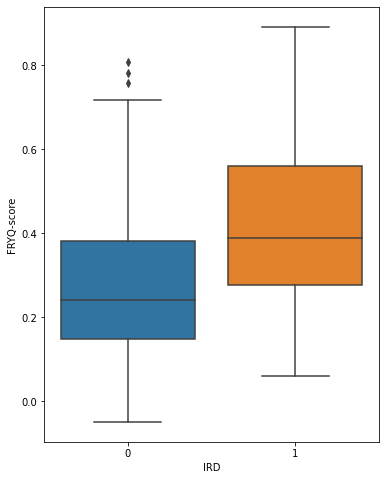

In [83]:
import seaborn as sns
from scipy.stats import ttest_ind

plt.figure(figsize=(6,8))
df_pred_repl = pd.DataFrame(y_pred_gold, columns=['pred'] )
df_pred_repl['IRD'] = y_label.astype(int)
#df_pred.boxplot(by='RA')
# Create a violin plot
sns.boxplot(x="IRD", y="pred", data=df_pred_repl)

# Perform t-test
stat, p_value = ttest_ind(df_pred_repl[df_pred_repl['IRD']==1]['pred'], df_pred_repl[df_pred_repl['IRD']==0]['pred'])

print(f"t-statistic: {stat}, p-value: {p_value}")

# Show the plot
plt.ylabel('FRYQ-score')
plt.show()

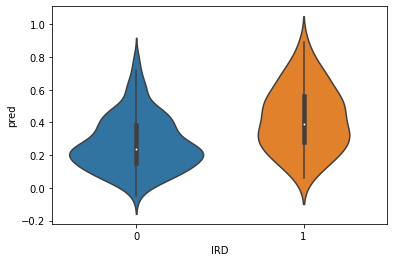

In [84]:
import seaborn as sns
df_pred_repl = pd.DataFrame(y_pred_gold, columns=['pred'] )
df_pred_repl['IRD'] = y_label.astype(int)
df_pred_repl['Sex'] = df_repl['Geslacht'].astype(int)
#df_pred.boxplot(by='RA')

# Create a violin plot
sns.violinplot(x="IRD", y="pred", data=df_pred_repl)

# Show the plot
plt.show()

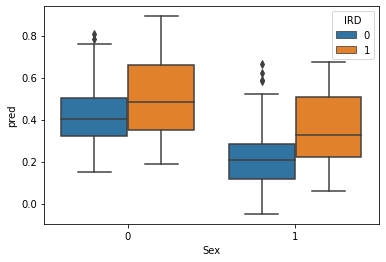

In [85]:

#df_pred.boxplot(by='RA')

# Create a violin plot
sns.boxplot(x="Sex", y="pred", data=df_pred_repl, hue='IRD')

# Show the plot
plt.show()

Brier score: 0.17338718654202082


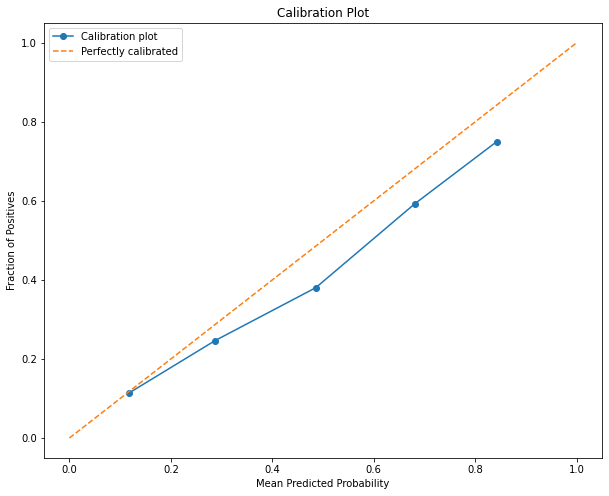

In [86]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# Create a calibration plot
plt.figure(figsize=(10,8))
df_pred_repl.loc[df_pred_repl['pred'] < 0, 'pred'] = 0
prob_true, prob_pred = calibration_curve(df_pred_repl['IRD'], df_pred_repl['pred'] , n_bins=5, strategy='uniform')
print('Brier score:', brier_score_loss(df_pred_repl['IRD'], df_pred_repl['pred']))

# Plot the calibration curve
plt.plot(prob_pred, prob_true, marker='o', label='Calibration plot')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend()
plt.show()

### Cut-off analysis Evaluate robustness of cut-off (0.3) in replication set

Text(0.5, 1.0, 'Confusion matrix for the XGBoost classifier in hold out set (ACC: 0.65)')

<Figure size 432x288 with 0 Axes>

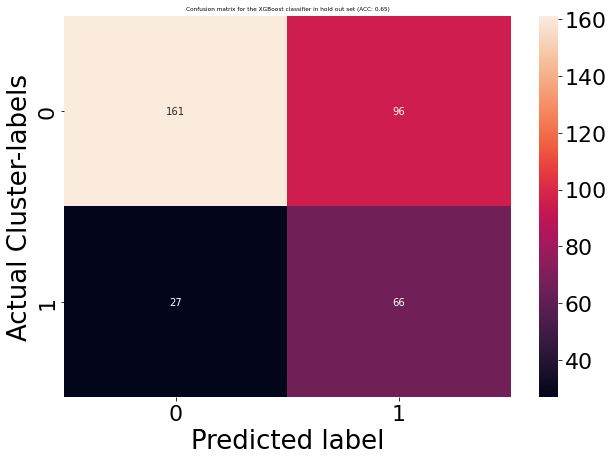

In [68]:
fig = plt.figure()
#cm = confusion_matrix(y, y_pred)
#accuracy = accuracy_score(y, y_pred)

threshold = 0.30
cm = confusion_matrix(y_label, np.array(y_pred_gold)> threshold).astype('float')
accuracy = accuracy_score(y_label, np.array(y_pred_gold)> threshold).astype('float')


df_cm = pd.DataFrame(cm, index = list(range(len(y_label.unique()))),
                  columns = list(range(len(y_label.unique()))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Predicted label")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the XGBoost classifier in hold out set (ACC: %.2f)' % (accuracy))

### Determine confidence intervals of test set

In [69]:
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
n_iterations = 100
auc_values = []

np.random.seed(0)
df_pred_repl = pd.DataFrame({ 'pred' : y_pred_gold, 'IRD' : y_label, 'DIAG' : y_granular_diag})
df_pred_repl = df_pred_repl.reset_index(drop=True)
roc_auc_score(df_pred_repl['IRD'], df_pred_repl['pred'])

for _ in range(n_iterations):
    # Resample with replacement
    indices = np.random.choice(len(df_pred_repl['IRD']), len(df_pred_repl['IRD']), replace=True)
    resampled_data = df_pred_repl.loc[indices]
    # Calculate AUC for the resampled dataset
    resampled_auc = roc_auc_score(resampled_data['IRD'], resampled_data['pred'])
    auc_values.append(resampled_auc)

# Calculate the confidence interval
confidence_interval = np.percentile(auc_values, [2.5, 97.5])

#print(f'Original AUC: {original_auc:.4f}')
print(f'95% Confidence Interval: {confidence_interval}')

95% Confidence Interval: [0.66187785 0.78380156]


### now of full model (in test)

In [88]:
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
n_iterations = 100
auc_values = []

np.random.seed(0)
df_pred_repl = pd.DataFrame({ 'pred' : y_pred_gold_all, 'IRD' : y_label, 'DIAG' : y_granular_diag})
df_pred_repl = df_pred_repl.reset_index(drop=True)
roc_auc_score(df_pred_repl['IRD'], df_pred_repl['pred'])

for _ in range(n_iterations):
    # Resample with replacement
    indices = np.random.choice(len(df_pred_repl['IRD']), len(df_pred_repl['IRD']), replace=True)
    resampled_data = df_pred_repl.loc[indices]
    # Calculate AUC for the resampled dataset
    resampled_auc = roc_auc_score(resampled_data['IRD'], resampled_data['pred'])
    auc_values.append(resampled_auc)

# Calculate the confidence interval
confidence_interval = np.percentile(auc_values, [2.5, 97.5])

#print(f'Original AUC: {original_auc:.4f}')
print(f'95% Confidence Interval: {confidence_interval}')

95% Confidence Interval: [0.64632254 0.76176947]


58.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
10.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


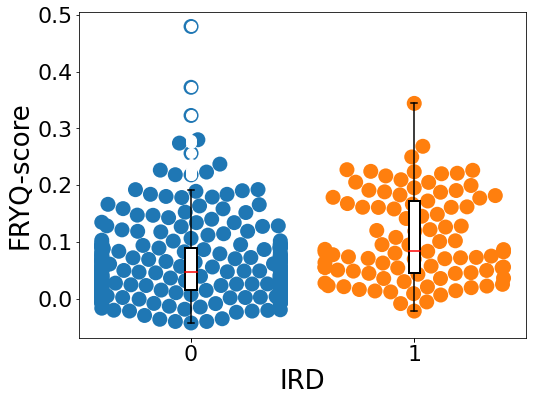

In [88]:
import seaborn as sns
params = {'legend.fontsize': 10,
          'figure.figsize': (8,6),
          'axes.grid': False,
         'axes.labelsize': 26,
         'axes.titlesize':'xx-small',
         'xtick.labelsize':22,
          'axes.labelcolor' : 'k',
          'ytick.color' : 'k',
          'xtick.color': 'k',
        'font.weight':'regular',
         'ytick.labelsize':22}
plt.rcParams.update(params)

# Create a violin plot
fig, ax = plt.subplots()

# Create a violin plot
df_pred_repl = pd.DataFrame({ 'pred' : y_pred_gold, 'IRD' : y_label, 'DIAG' : y_granular_diag})
df_pred_repl = df_pred_repl.reset_index(drop=True)
sns.swarmplot(x="IRD", y="pred", ax=ax, data=df_pred_repl, zorder=0, size=15)

for category in [0, 1]:
    subset = df_pred_repl[df_pred_repl['IRD'] == category]['pred']
    ax.boxplot(subset, positions=[category], widths=0.05, patch_artist=True, boxprops=dict(color='black', facecolor='white', linewidth=2), 
               medianprops=dict(color='red', linewidth=1.5), whiskerprops=dict(color='black', linewidth=1.5), capprops=dict(color='black', linewidth=1.5), 
               flierprops=dict(markerfacecolor='white', marker='o', markersize=10, linestyle='none',  linewidth=2, markeredgecolor='white'))
ax.set_ylabel('FRYQ-score')
# Show the plot
plt.show()

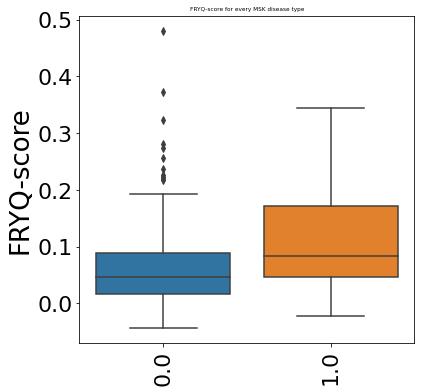

In [89]:
# Create boxplot with Seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(data=df_pred_repl, x='IRD', y='pred')
plt.title('FRYQ-score for every MSK disease type')
plt.xlabel('')
plt.ylabel('FRYQ-score')
# Rotate x-axis labels
plt.xticks(rotation=90)
plt.show()

In [90]:
df_pred_repl['DIAG'] = df_pred_repl['DIAG'].replace('reactief artritis', 'reactieve artritis').replace('Sjogren', 'Sjögren').replace('Ongedeferentieerd artritis', 'ongedifferentieerde artritis')
df_pred_repl.loc[df_pred_repl['pred'] < 0, 'pred'] = 0
df_pred_repl['DIAG_form'] = df_pred_repl['DIAG'].apply(lambda x : d_final_labels[x]) # d_IRD_GP

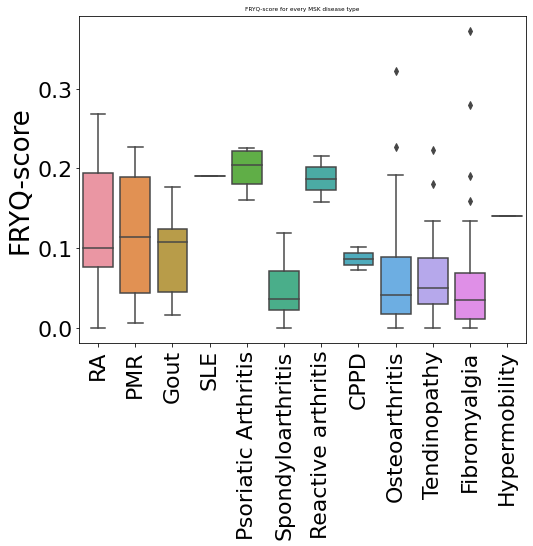

In [91]:

# Create boxplot with Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_pred_repl, x='DIAG_form', y='pred', order = l_order)
plt.title('FRYQ-score for every MSK disease type')
plt.xlabel('')
plt.ylabel('FRYQ-score')
# Rotate x-axis labels
plt.xticks(rotation=90)
plt.show()

In [81]:
import shap

N_FEAT = 15
t0 = time.time()
t_explainer = shap.TreeExplainer(final_model, feature_names=[inverted_dict[x] for x in l_elastic]) # or just X? ,  feature_names=tfidf_feature_names
shap_values = t_explainer( df_repl[l_elastic], y_pred_gold)
t1 = time.time()
print('Calculating SHAP: ' + str(t1-t0))

Calculating SHAP: 0.02433180809020996


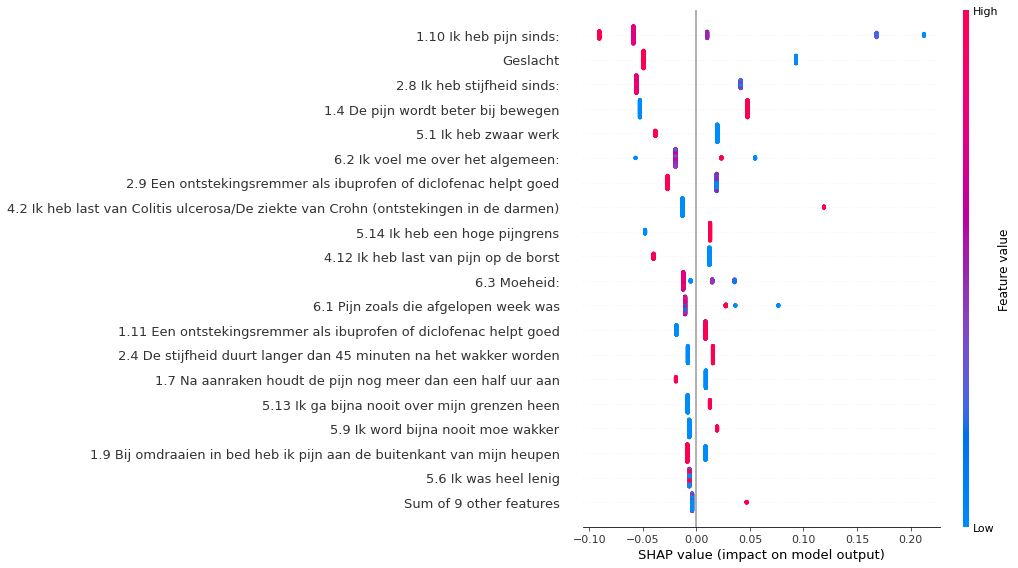

<Figure size 432x288 with 0 Axes>

In [117]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  
shap_values.feature_names = [inverted_dict[x] for x in l_elastic]
shap.plots.beeswarm(shap_values, max_display=20, show=True)

#plt.savefig('figures/shap_top%s_IRD.png' % (str(N_FEAT)), dpi=100, bbox_inches='tight')
# Save the figure
#plt.close()  # Close the figure to prevent displaying again
plt.clf()